In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
!"{sys.executable}" -m pip install --upgrade sentence-transformers numpy pandas scikit-learn matplotlib seaborn plotly umap-learn openpyxl

In [32]:
df = pd.read_csv('recipe_comparison_aligned.csv')
df.to_excel('recipe_comparison.xlsx', index=False)

In [8]:
!"{sys.executable}" -m pip uninstall sentence-transformers numpy pandas scikit-learn matplotlib seaborn plotly umap-learn 

Found existing installation: sentence-transformers 5.0.0
Uninstalling sentence-transformers-5.0.0:
  Would remove:
    /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sentence_transformers-5.0.0.dist-info/*
    /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sentence_transformers/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [6]:
!"{sys.executable}" -m pip install nbformat>=4.2.0

In [1]:
import json
import pandas as pd
import numpy as np

root_dir = os.getcwd()
data_dir = os.path.join(root_dir, 'data')
recipe_json_list = os.listdir(data_dir)
recipe_json_list = [file for file in recipe_json_list if file[-5:] == '.json' ]
print(recipe_json_list)
print(len(recipe_json_list))

['0000015685_000000000000163237_50821501_MIXED BERRY EHR.json', '0000015685_000000000000236669_2883200000_BLACK CHERRY MARVEL NON GMO.json', '0000015685_000000000000237330_2882880000_PEACH MARVEL NON GMO.json', '0000015685_000000000000271705__RASPBERRY PRESERVE.json', '0000015685_000000000000279175__CARAMEL FOT.json', '0000015685_000000000000279176__CARAMEL APPLE.json', '0000015685_000000000000279183__PECAN.json', '0000015685_000000000000303436__STRAWBERRY SPEZIAL JUST 3.json', '0000015685_000000000000303637__TROPICAL SPEZIAL JUST 3.json', '0000015685_000000000000306296__MIXED BERRY JUST 3.json', '0000015685_000000000000378045__STRAWBERRY INDULGENT.json', '0000015685_000000000000380277__VANILLA DELUXE.json', '0000015685_000000000000382601__COFFEE LUXE.json', '0000017883_000000000000238673_PEANUT CARAMEL_521022.json', '0000017883_000000000000238674_521018_SALTED CARAMEL.json', '0000017883_000000000000238675_FRUIT - CHO BANANA_521124.json', '0000017883_000000000000240905_PCBFRUITPCHBANAN

In [2]:
def read_recipe_json(recipe_json):
    result = None
    try:
        with open(os.path.join(data_dir, recipe_json), 'r', encoding='utf-8') as f:
            data = json.load(f)
            print(os.path.join(data_dir, recipe_json)[-50:])
        
        if not data:
            print(f" The JSON file {recipe_json} is empty")
        elif 'Classification' in data.keys() and data['Classification'] and 'valueschar' in data['Classification'] and data['Classification']['valueschar']:
            result = pd.DataFrame(data['Classification']['valueschar'])
        else:
            print(f"Classification/valueschar not found in {recipe_json}")
    except Exception as e:
        print(f"Error reading {recipe_json}: {e}")
    
    return result

In [17]:
import uuid
from typing import List, Dict, Any, Optional, Union
from dataclasses import dataclass
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import logging
import pickle
import json

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class Recipe:
    """Data class representing a recipe with features and their values."""
    id: str
    features: List[str]  # Feature names
    values: List[Any]    # Feature values (can be text, numbers, etc.)
    metadata: Optional[Dict[str, Any]] = None

class CategoricalRecipeQdrantManager:
    """
    A class to manage recipe storage and similarity search using FAISS
    for categorical/structured recipe data.
    """
    
    def __init__(self, 
                 host: str = "localhost", 
                 port: int = 6333,
                 collection_name: str = "categorical_recipes",
                 embedding_model: str = "all-MiniLM-L6-v2",
                 max_features: int = 100):
        """
        Initialize the FAISS-based manager and embedding model.
        
        Args:
            host: Ignored 
            port: Ignored 
            collection_name: Name of the collection to store recipes
            embedding_model: Sentence transformer model for text embeddings
            max_features: Maximum number of features to handle
        """
        self.collection_name = collection_name
        self.embedding_model = SentenceTransformer(embedding_model)
        self.max_features = max_features
        
        # Feature encoders for categorical data
        self.feature_encoders = {}
        self.all_feature_names = set()
        
        # FAISS-like storage
        self.recipes = []  # Store recipe data
        self.vectors = []  # Store vectors
        self.recipe_index = {}  # Map recipe IDs to indices
        
        # Initialize collection if it doesn't exist
        self._initialize_collection()
    
    def _initialize_collection(self):
        """Initialize the in-memory collection."""
        try:
            logger.info(f"Created collection: {self.collection_name}")
        except Exception as e:
            logger.error(f"Error initializing collection: {e}")
            raise
    
    def _clean_value(self, value: Any) -> str:
        """Clean and normalize a value."""
        if pd.isna(value) or value is None or str(value).strip() == '':
            return "MISSING"
        return str(value).strip()
    
    def _create_feature_text(self, features: List[str], values: List[Any]) -> str:
        """
        Create a text representation of features and values for embedding.
        
        Args:
            features: List of feature names
            values: List of feature values
            
        Returns:
            Combined text string
        """
        feature_texts = []
        for feature, value in zip(features, values):
            clean_value = self._clean_value(value)
            if clean_value != "MISSING":
                feature_texts.append(f"{feature}: {clean_value}")
        
        return " | ".join(feature_texts)
    
    def _encode_categorical_features(self, features: List[str], values: List[Any], fit: bool = False) -> np.ndarray:
        """
        Encode categorical features into numerical vectors.
        
        Args:
            features: List of feature names
            values: List of feature values
            fit: Whether to fit encoders (True for training, False for inference)
            
        Returns:
            Encoded feature vector
        """
        # Create a standardized feature dictionary
        feature_dict = {}
        for feature, value in zip(features, values):
            clean_value = self._clean_value(value)
            feature_dict[feature] = clean_value
        
        # Update known features
        if fit:
            self.all_feature_names.update(features)
        
        # Create a fixed-size vector
        encoded_vector = np.zeros(self.max_features)
        
        # Get sorted list of all known features for consistent ordering
        sorted_features = sorted(list(self.all_feature_names))[:self.max_features]
        
        for i, feature_name in enumerate(sorted_features):
            if feature_name in feature_dict:
                value = feature_dict[feature_name]
                
                # Initialize encoder if needed
                if fit and feature_name not in self.feature_encoders:
                    self.feature_encoders[feature_name] = LabelEncoder()
                
                if feature_name in self.feature_encoders:
                    try:
                        if fit:
                            # Fit and transform
                            if not hasattr(self.feature_encoders[feature_name], 'classes_'):
                                encoded_vector[i] = self.feature_encoders[feature_name].fit_transform([value])[0]
                            else:
                                # Update existing encoder
                                known_classes = set(self.feature_encoders[feature_name].classes_)
                                if value not in known_classes:
                                    # Add new class
                                    new_classes = list(known_classes) + [value]
                                    self.feature_encoders[feature_name].classes_ = np.array(new_classes)
                                encoded_vector[i] = self.feature_encoders[feature_name].transform([value])[0]
                        else:
                            # Transform only
                            if hasattr(self.feature_encoders[feature_name], 'classes_'):
                                if value in self.feature_encoders[feature_name].classes_:
                                    encoded_vector[i] = self.feature_encoders[feature_name].transform([value])[0]
                                else:
                                    # Unknown value - use default
                                    encoded_vector[i] = -1
                    except Exception as e:
                        logger.warning(f"Error encoding {feature_name}={value}: {e}")
                        encoded_vector[i] = -1
        
        # Normalize the encoded vector
        if np.std(encoded_vector) > 0:
            encoded_vector = (encoded_vector - np.mean(encoded_vector)) / np.std(encoded_vector)
        
        return encoded_vector
    
    def _create_combined_vector(self, features: List[str], values: List[Any], fit: bool = False) -> np.ndarray:
        """
        Create a combined vector from recipe features and values.
        
        Args:
            features: List of feature names
            values: List of feature values
            fit: Whether to fit encoders
            
        Returns:
            Combined vector as numpy array
        """
        # Create text representation for embedding
        feature_text = self._create_feature_text(features, values)
        
        # Generate text embedding
        text_embedding = self.embedding_model.encode(feature_text)
        
        # Encode categorical features
        categorical_vector = self._encode_categorical_features(features, values, fit=fit)
        
        # Combine embeddings
        combined_vector = np.concatenate([text_embedding, categorical_vector])
        
        return combined_vector
    
    def update_recipes(self, features_list: List[List[str]], values_list: List[List[Any]], 
                      recipe_ids: Optional[List[str]] = None,
                      metadata_list: Optional[List[Dict[str, Any]]] = None) -> bool:
        """
        Update the recipe store with a list of recipes.
        
        Args:
            features_list: List of feature name lists for each recipe
            values_list: List of feature value lists for each recipe
            recipe_ids: Optional list of recipe IDs (auto-generated if not provided)
            metadata_list: Optional list of additional metadata for each recipe
            
        Returns:
            True if successful, False otherwise
        """
        try:
            if len(features_list) != len(values_list):
                raise ValueError("Features and values lists must have the same length")
            
            if recipe_ids and len(recipe_ids) != len(features_list):
                raise ValueError("Recipe IDs list length must match features length")
            
            if metadata_list and len(metadata_list) != len(features_list):
                raise ValueError("Metadata list length must match features length")
            
            for i, (features, values) in enumerate(zip(features_list, values_list)):
                # Handle length mismatch between features and values
                min_length = min(len(features), len(values))
                features = features[:min_length]
                values = values[:min_length]
                
                # Generate unique ID
                recipe_id = recipe_ids[i] if recipe_ids else str(uuid.uuid4())
                
                # Create combined vector (fit encoders during training)
                vector = self._create_combined_vector(features, values, fit=True)
                
                # Prepare payload (equivalent to Qdrant payload)
                payload = {
                    "features": features,
                    "values": [self._clean_value(v) for v in values],
                    "recipe_id": recipe_id,
                    "feature_text": self._create_feature_text(features, values)
                }
                
                if metadata_list and i < len(metadata_list):
                    payload.update(metadata_list[i])
                
                # Store recipe data and vector
                recipe_data = {
                    "id": recipe_id,
                    "vector": vector,
                    "payload": payload
                }
                
                self.recipes.append(recipe_data)
                self.vectors.append(vector)
                self.recipe_index[recipe_id] = len(self.recipes) - 1
            
            logger.info(f"Successfully updated {len(features_list)} recipes")
            return True
            
        except Exception as e:
            logger.error(f"Error updating recipes: {e}")
            return False
    
    def search_similar_recipes(self, query_features: List[str], query_values: List[Any],
                             top_k: int = 3) -> List[Dict[str, Any]]:
        """
        Search for similar recipes based on features and values.
        
        Args:
            query_features: List of feature names for the query
            query_values: List of feature values for the query
            top_k: Number of similar recipes to return (default: 3)
            
        Returns:
            List of similar recipes with scores
        """
        try:
            if len(self.vectors) == 0:
                logger.error("No recipes stored. Please update recipes first.")
                return []
            
            # Handle length mismatch
            min_length = min(len(query_features), len(query_values))
            query_features = query_features[:min_length]
            query_values = query_values[:min_length]
            
            # Create query vector (don't fit encoders during search)
            query_vector = self._create_combined_vector(query_features, query_values, fit=False)
            
            # Calculate similarities using cosine similarity
            stored_vectors = np.array(self.vectors)
            similarities = cosine_similarity([query_vector], stored_vectors)[0]
            
            # Get top-k most similar recipes
            top_indices = np.argsort(similarities)[::-1][:top_k]
            
            # Format results (same format as Qdrant)
            similar_recipes = []
            for idx in top_indices:
                recipe = self.recipes[idx]
                recipe_data = {
                    "id": recipe["id"],
                    "score": float(similarities[idx]),
                    "features": recipe["payload"].get("features", []),
                    "values": recipe["payload"].get("values", []),
                    "feature_text": recipe["payload"].get("feature_text", ""),
                    "metadata": {k: v for k, v in recipe["payload"].items() 
                               if k not in ["features", "values", "recipe_id", "feature_text"]}
                }
                similar_recipes.append(recipe_data)
            
            logger.info(f"Found {len(similar_recipes)} similar recipes")
            return similar_recipes
            
        except Exception as e:
            logger.error(f"Error searching similar recipes: {e}")
            return []
    
    def get_recipe_by_id(self, recipe_id: str) -> Optional[Dict[str, Any]]:
        """Retrieve a specific recipe by ID."""
        try:
            if recipe_id in self.recipe_index:
                recipe = self.recipes[self.recipe_index[recipe_id]]
                return {
                    "id": recipe["id"],
                    "features": recipe["payload"].get("features", []),
                    "values": recipe["payload"].get("values", []),
                    "feature_text": recipe["payload"].get("feature_text", ""),
                    "metadata": {k: v for k, v in recipe["payload"].items() 
                               if k not in ["features", "values", "recipe_id", "feature_text"]}
                }
            return None
            
        except Exception as e:
            logger.error(f"Error retrieving recipe {recipe_id}: {e}")
            return None
    
    def save_encoders(self, filepath: str):
        """Save feature encoders to file."""
        try:
            encoder_data = {
                'feature_encoders': self.feature_encoders,
                'all_feature_names': list(self.all_feature_names),
                'recipes': self.recipes,
                'vectors': self.vectors,
                'recipe_index': self.recipe_index
            }
            with open(filepath, 'wb') as f:
                pickle.dump(encoder_data, f)
            logger.info(f"Encoders saved to {filepath}")
        except Exception as e:
            logger.error(f"Error saving encoders: {e}")
    
    def load_encoders(self, filepath: str):
        """Load feature encoders from file."""
        try:
            with open(filepath, 'rb') as f:
                encoder_data = pickle.load(f)
            self.feature_encoders = encoder_data['feature_encoders']
            self.all_feature_names = set(encoder_data['all_feature_names'])
            self.recipes = encoder_data.get('recipes', [])
            self.vectors = encoder_data.get('vectors', [])
            self.recipe_index = encoder_data.get('recipe_index', {})
            logger.info(f"Encoders loaded from {filepath}")
        except Exception as e:
            logger.error(f"Error loading encoders: {e}")
    
    def get_stats(self) -> Dict[str, Any]:
        """Get statistics about the stored recipes."""
        return {
            "total_recipes": len(self.recipes),
            "total_features": len(self.all_feature_names),
            "vector_dimension": len(self.vectors[0]) if self.vectors else 0,
            "embedding_method": "sentence_transformers",
            "collection_name": self.collection_name
        }

In [3]:
def read_recipe_json(recipe_json):
    result = None
    try:
        with open(os.path.join(data_dir, recipe_json), 'r', encoding='utf-8') as f:
            data = json.load(f)
            print(os.path.join(data_dir, recipe_json)[-50:])
        
        if not data:
            print(f" The JSON file {recipe_json} is empty")
        elif 'Classification' in data.keys() and data['Classification'] and 'valueschar' in data['Classification'] and data['Classification']['valueschar']:
            result = pd.DataFrame(data['Classification']['valueschar'])
        else:
            print(f"Classification/valueschar not found in {recipe_json}")
    except Exception as e:
        print(f"Error reading {recipe_json}: {e}")
    
    return result

########

# Initialize the manager
manager = CategoricalRecipeQdrantManager(max_features=50)

# Update recipes with different lengths
features_list = []
values_list = []
metadata_list = []
recipe_json_list = sorted(recipe_json_list)

print(f"Processing {len(recipe_json_list)} recipes...")

for i in range(len(recipe_json_list)):
    # First get the raw result
    recipe_data = read_recipe_json(recipe_json_list[i])
    
    # Check if we got valid data AND it has the required columns
    if recipe_data is not None and isinstance(recipe_data, pd.DataFrame):
        if 'charactDescr' in recipe_data.columns and 'valueCharLong' in recipe_data.columns:
            # Now safely access the columns
            recipe_temp = recipe_data[['charactDescr', 'valueCharLong']]
            features_list.append(recipe_temp['charactDescr'])
            values_list.append(recipe_temp['valueCharLong'])
            metadata_list.append({"recipe_name": recipe_json_list[i].split('.')[0]})
            print(f"Added recipe {i+1}/{len(recipe_json_list)}: {recipe_json_list[i]}")
        else:
            print(f"Missing required columns in {recipe_json_list[i]}")
    else:
        print(f"Skipping invalid recipe {i+1}/{len(recipe_json_list)}: {recipe_json_list[i]}")

print(f"\nSuccessfully processed {len(features_list)} recipes out of {len(recipe_json_list)}")

# Only proceed if we have valid recipes
if len(features_list) > 0:
    success = manager.update_recipes(
        features_list=features_list,
        values_list=values_list,
        metadata_list=metadata_list
    )
    
    if success:
        print("Recipes updated successfully!")
        print(f"Stats: {manager.get_stats()}")
    else:
        print("Failed to store recipes")
else:
    print("No valid recipes found to process!")

NameError: name 'CategoricalRecipeQdrantManager' is not defined

## Search for similar recipes

In [2]:
def search_similar_recipes(query_features, query_values, top_k=3):
    print(f"\n Searching for recipes similar to: {dict(zip(query_features, query_values))}")
    similar_recipes = manager.search_similar_recipes(
        query_features=query_features,
        query_values=query_values,
        top_k=top_k
    )
    print(f"\n Found {len(similar_recipes)} similar recipes:")
    for i, recipe in enumerate(similar_recipes, 1):
        print(f"\n{i}.  Similarity Score: {recipe['score']:.3f}")
        print(f"Features ({len(recipe['features'])}): {recipe['features']}")
        print(f"Values: {recipe['values']}")
        print(f"Metadata: {recipe['metadata']}")

    # Create comparison dataframe
    print(f"\n{'='*80}")
    print("COMPARISON DATAFRAME")
    print(f"{'='*80}")

    # Prepare data for dataframe
    max_features = max(
        len(query_features),
        max([len(recipe['features']) for recipe in similar_recipes]) if similar_recipes else 0
    )

    # Create the dataframe columns
    columns = ['Query_Features', 'Query_Values']
    for i in range(min(3, len(similar_recipes))):
        columns.extend([f'Similar_{i+1}_Features', f'Similar_{i+1}_Values'])

    # Pad all lists to the same length
    def pad_list(lst, target_length):
        return list(lst) + [''] * (target_length - len(lst))

    # Prepare data
    data = {
        'Query_Features': pad_list(query_features, max_features),
        'Query_Values': pad_list(query_values, max_features)
    }

    # Add similar recipes data
    for i in range(min(3, len(similar_recipes))):
        recipe = similar_recipes[i]
        data[f'Similar_{i+1}_Features'] = pad_list(recipe['features'], max_features)
        data[f'Similar_{i+1}_Values'] = pad_list(recipe['values'], max_features)

    # Fill missing columns if we have fewer than 3 similar recipes
    for i in range(len(similar_recipes), 3):
        data[f'Similar_{i+1}_Features'] = [''] * max_features
        data[f'Similar_{i+1}_Values'] = [''] * max_features

    # Create dataframe
    comparison_df = pd.DataFrame(data)


    # Optional: Save to CSV for easier viewing
    comparison_df.to_csv('recipe_comparison.csv', index=False)
    print(f"\n Comparison saved to 'recipe_comparison.csv'")

    # Display summary with scores
    print(f"\n SIMILARITY SCORES:")
    for i, recipe in enumerate(similar_recipes, 1):
        recipe_name = recipe['metadata'].get('recipe_name', f'Recipe_{i}')
        print(f"   {i}. {recipe_name}: {recipe['score']:.4f}")

    # Display the dataframe
    return comparison_df

In [23]:
def search_similar_recipes(query_features, query_values, top_k=3):
    print(f"\n Searching for recipes similar to: {dict(zip(query_features, query_values))}")
    similar_recipes = manager.search_similar_recipes(
        query_features=query_features,
        query_values=query_values,
        top_k=top_k
    )
    print(f"\n Found {len(similar_recipes)} similar recipes:")
    for i, recipe in enumerate(similar_recipes, 1):
        print(f"\n{i}.  Similarity Score: {recipe['score']:.3f}")
        print(f"Features ({len(recipe['features'])}): {recipe['features']}")
        print(f"Values: {recipe['values']}")
        print(f"Metadata: {recipe['metadata']}")
    
    # Create comparison dataframe with aligned features
    print(f"\n{'='*80}")
    print("COMPARISON DATAFRAME (FEATURE-ALIGNED)")
    print(f"{'='*80}")
    
    def align_recipe_with_query(recipe_features, recipe_values, query_features):
        """
        Align recipe features/values with query order and collect additional features.
        
        Returns:
            aligned_features, aligned_values, extra_features, extra_values
        """
        # Create mapping of recipe features to values
        recipe_dict = dict(zip(recipe_features, recipe_values))
        
        # Align with query order
        aligned_features = []
        aligned_values = []
        
        for query_feature in query_features:
            if query_feature in recipe_dict:
                aligned_features.append(query_feature)
                aligned_values.append(recipe_dict[query_feature])
            else:
                aligned_features.append(query_feature)
                aligned_values.append('')  # Missing feature
        
        # Collect additional features not in query
        extra_features = []
        extra_values = []
        for feature, value in zip(recipe_features, recipe_values):
            if feature not in query_features:
                extra_features.append(feature)
                extra_values.append(value)
        
        return aligned_features, aligned_values, extra_features, extra_values
    
    # Process all similar recipes
    aligned_recipes = []
    all_extra_features = set()
    
    for recipe in similar_recipes:
        aligned_feat, aligned_val, extra_feat, extra_val = align_recipe_with_query(
            recipe['features'], recipe['values'], query_features
        )
        aligned_recipes.append({
            'aligned_features': aligned_feat,
            'aligned_values': aligned_val,
            'extra_features': extra_feat,
            'extra_values': extra_val,
            'score': recipe['score'],
            'metadata': recipe['metadata']
        })
        all_extra_features.update(extra_feat)
    
    # Create comprehensive feature list: query features + all extra features
    all_extra_features = sorted(list(all_extra_features))
    comprehensive_features = list(query_features) + all_extra_features
    
    # Prepare data for dataframe
    data = {
        'Query_Features': list(query_features) + all_extra_features,
        'Query_Values': list(query_values) + [''] * len(all_extra_features)
    }
    
    # Add aligned similar recipes data
    for i, aligned_recipe in enumerate(aligned_recipes[:3]):
        recipe_num = i + 1
        
        # Get aligned values for query features
        recipe_aligned_values = aligned_recipe['aligned_values'].copy()
        
        # Add values for extra features
        extra_dict = dict(zip(aligned_recipe['extra_features'], aligned_recipe['extra_values']))
        for extra_feature in all_extra_features:
            if extra_feature in extra_dict:
                recipe_aligned_values.append(extra_dict[extra_feature])
            else:
                recipe_aligned_values.append('')  # Recipe doesn't have this extra feature
        
        data[f'Similar_{recipe_num}_Features'] = comprehensive_features
        data[f'Similar_{recipe_num}_Values'] = recipe_aligned_values
    
    # Fill missing columns if we have fewer than 3 similar recipes
    for i in range(len(similar_recipes), 3):
        recipe_num = i + 1
        data[f'Similar_{recipe_num}_Features'] = [''] * len(comprehensive_features)
        data[f'Similar_{recipe_num}_Values'] = [''] * len(comprehensive_features)
    
    # Create dataframe
    comparison_df = pd.DataFrame(data)
    
    # Add highlighting for exact matches
    def highlight_matches(df):
        """Add a column showing which rows have exact feature-value matches."""
        match_indicators = []
        query_pairs = set(zip(df['Query_Features'], df['Query_Values']))
        
        for idx, row in df.iterrows():
            matches = []
            for col_num in range(1, 4):  # Check Similar_1, Similar_2, Similar_3
                feat_col = f'Similar_{col_num}_Features'
                val_col = f'Similar_{col_num}_Values'
                if feat_col in df.columns and val_col in df.columns:
                    if (row['Query_Features'], row['Query_Values']) == (row[feat_col], row[val_col]):
                        if row['Query_Features'] != '' and row['Query_Values'] != '':
                            matches.append(f'✓{col_num}')
            match_indicators.append(' '.join(matches) if matches else '')
        
        df['Exact_Matches'] = match_indicators
        return df
    
    comparison_df = highlight_matches(comparison_df)
    
    # Display the dataframe
    print("\nFeature-Aligned Comparison:")
    print("=" * 120)
    
    # Show query features section
    query_end_idx = len(query_features)
    if query_end_idx > 0:
        print("\n QUERY FEATURES COMPARISON:")
        query_section = comparison_df.iloc[:query_end_idx]
        print(query_section.to_string(index=False))
    
    # Show additional features section
    if len(all_extra_features) > 0:
        print(f"\n ADDITIONAL FEATURES FROM SIMILAR RECIPES:")
        extra_section = comparison_df.iloc[query_end_idx:]
        print(extra_section.to_string(index=False))
    
    # Show feature matching summary
    print(f"\n FEATURE MATCHING SUMMARY:")
    for i, aligned_recipe in enumerate(aligned_recipes[:3]):
        recipe_name = aligned_recipe['metadata'].get('recipe_name', f'Recipe_{i+1}')
        score = aligned_recipe['score']
        
        # Count exact matches
        query_dict = dict(zip(query_features, query_values))
        recipe_dict = dict(zip(aligned_recipe['aligned_features'], aligned_recipe['aligned_values']))
        
        exact_matches = 0
        total_query_features = len([f for f in query_features if f != ''])
        
        for qf, qv in query_dict.items():
            if qf in recipe_dict and recipe_dict[qf] == qv and qv != '':
                exact_matches += 1
        
        match_percentage = (exact_matches / total_query_features * 100) if total_query_features > 0 else 0
        
        print(f"   {i+1}. {recipe_name}")
        print(f"      Similarity Score: {score:.4f}")
        print(f"      Exact Feature Matches: {exact_matches}/{total_query_features} ({match_percentage:.1f}%)")
        print(f"      Additional Features: {len(aligned_recipe['extra_features'])}")
    
    # Create summary table for Excel export
    summary_data = []
    for i, recipe in enumerate(similar_recipes, 1):
        # Extract clean filename from metadata
        file_name = recipe['metadata'].get('recipe_name', f'Recipe_{i}')
        
        summary_data.append({
            'Top_k': i,
            'File_Name': file_name,
            'Similarity_Score': round(recipe['score'], 4)
        })
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(summary_data)
    
    # Save both tables to Excel with multiple sheets
    with pd.ExcelWriter('recipe_analysis_results.xlsx', engine='openpyxl') as writer:
        # Sheet 1: Detailed comparison
        comparison_df.to_excel(writer, sheet_name='Detailed_Comparison', index=False)
        
        # Sheet 2: Summary table
        summary_df.to_excel(writer, sheet_name='Similarity_Summary', index=False)
        
        # Sheet 3: Query information
        query_info_df = pd.DataFrame({
            'Query_Features': query_features,
            'Query_Values': query_values
        })
        query_info_df.to_excel(writer, sheet_name='Query_Info', index=False)
    
    print(f"\n📊 SIMILARITY SUMMARY TABLE:")
    print("=" * 60)
    print(summary_df.to_string(index=False))
    
    print(f"\n💾 Complete analysis saved to 'recipe_analysis_results.xlsx'")
    print("   📋 Sheet 1: Detailed_Comparison - Full feature comparison")
    print("   📊 Sheet 2: Similarity_Summary - Top-k results table")
    print("   🔍 Sheet 3: Query_Info - Original query details")
    
    # Also save just the summary table separately
    summary_df.to_excel('similarity_summary.xlsx', index=False)
    print(f"📋 Summary table also saved separately to 'similarity_summary.xlsx'")
    
    return comparison_df, summary_df


# Example usage with enhanced readability
def display_aligned_comparison(query_features, query_values, top_k=3):
    """Enhanced version with better visualization."""
    comparison_df, summary_df = search_similar_recipes(query_features, query_values, top_k)
    
    # Create a more readable summary table
    print(f"\n{'='*100}")
    print("📋 SIDE-BY-SIDE FEATURE COMPARISON")
    print(f"{'='*100}")
    
    # Show only the most important comparisons in a clean format
    query_dict = dict(zip(query_features, query_values))
    
    print(f"{'Feature':<30} {'Query Value':<20} {'Similar 1':<20} {'Similar 2':<20} {'Similar 3':<20}")
    print("-" * 110)
    
    for feature in query_features[:10]:  # Show first 10 features
        if feature and feature != '':
            row_data = comparison_df[comparison_df['Query_Features'] == feature]
            if not row_data.empty:
                row = row_data.iloc[0]
                similar_1 = row.get('Similar_1_Values', '')
                similar_2 = row.get('Similar_2_Values', '')
                similar_3 = row.get('Similar_3_Values', '')
                
                # Add indicators for matches
                s1_match = '✓' if similar_1 == query_dict[feature] and similar_1 != '' else ''
                s2_match = '✓' if similar_2 == query_dict[feature] and similar_2 != '' else ''
                s3_match = '✓' if similar_3 == query_dict[feature] and similar_3 != '' else ''
                
                print(f"{feature[:29]:<30} {query_dict[feature][:19]:<20} {(similar_1 + s1_match)[:19]:<20} {(similar_2 + s2_match)[:19]:<20} {(similar_3 + s3_match)[:19]:<20}")
    
    # Filter based on the characteristics of the initial query vector
    filtered_comparison = comparison_df[comparison_df['Query_Features'].isin(query_features)]
    
    return comparison_df, summary_df, filtered_comparison

In [43]:
query_df =read_recipe_json(recipe_json_list[0])[['charactDescr', 'valueCharLong']]
query_df

5_000000000000163237_50821501_MIXED BERRY EHR.json


,charactDescr,valueCharLong
0,Annatto,No
1,Carmine,No
2,Customer Brand,No Entry
3,Industry (SD Reporting),Dairy
4,Sweetener,Sweetener
5,Saccharose,Saccarose
6,Preserved,preservative
7,Artificial colors,No artificial colors
8,Nature identical flavor,No nature identical flavour
9,Natural flavor,Natural flavour


In [10]:
query_df.iloc[1,1] = 'Yes'
query_df.iloc[2,1] = 'Yes'
query_df

,charactDescr,valueCharLong
0,Mkt. Category - Level 2,Flavored Yogurt
1,Clean label - Native stabilize,Yes
2,Clean label - No additives,Yes
3,Contact - email,MEGHAN.VANDENHOOVEN@AGRANA.COM
4,Contact - Name,MEGHAN VAN DEN HOOVEN
5,EOI - Traffic Light,Green
6,Puree/with pieces,puree
7,Fruit Prep Application,Blended
8,Flavor status,"nat.flavor (inc.nat.,WONF,95/5"
9,Industry (SD Reporting),Dairy


In [9]:
print(recipe_json_list[0])

0000017883_000000000000238673_PEANUT CARAMEL_521022.json


54

56

In [24]:
query_df = pd.DataFrame({
    'charactDescr': [
        "Color code", "Sweetener", "Saccharose", "Preserved", "Artificial colors",
        "Nature identical flavor", "Natural flavor", "Contains GMO", "Flavour",
        "Without rework", "Same rework", "Allergens", "Starch", "Pectin", "LBG",
        "Blend", "Other stabilizer", "Color", "Quantity Sulfite [ppm]", "Aspartame",
        "Brix", "Dosage", "Fruit content", "Project title", "Allergenstring (from recipe)",
        "Carmine", "Annatto", "Fortified", "Kosher Type", "Organic certification",
        "Product Line", "Customer Brand", "ADM Material", "Produktsegment (SD Reporting)",
        "Industry (SD Reporting)", "Plant-based", "Launch Type", "NPD Innovation",
        "Related Material", "Almond", "Beech Nut", "Brazil Nut", "Butternut", "Cashew",
        "Chestnut", "Chinquapin", "Coconut", "Ginko Nut", "Hazelnut", "Heartnut",
        "Hickory Nut", "Lichee Nut", "Macadamia Nut", "Pecan"
    ],
    'valueCharLong': [
        "116.900.324.161", "No sweetener", "No saccharose", "No preservative", "No artificial colors",
        "No nature identical flavour", "Natural flavour", "Not gene manipulated", "Flavour",
        None, None, "No allergens", "Starch", "No pectin", "No LBG",
        "No blend", "Other stabilizer", "Color", None, "No Aspartame",
        "13,0", None, "40,0 %", None, None,
        None, None, None, None, None, None, None, None,
        None, "Spoonable Yoghurt", "Dairy",
        "Non-Plant-based", "New Product", "No",
        None, None, None, None, None, None,
        None, None, None, None, None,
        None, None, None, None
    ]
})

query_df

,charactDescr,valueCharLong
0,Color code,116.900.324.161
1,Sweetener,No sweetener
2,Saccharose,No saccharose
3,Preserved,No preservative
4,Artificial colors,No artificial colors
5,Nature identical flavor,No nature identical flavour
6,Natural flavor,Natural flavour
7,Contains GMO,Not gene manipulated
8,Flavour,Flavour
9,Without rework,None


In [11]:
query_df = pd.DataFrame({
    'charactDescr': [
        "Color code", "Sweetener", "Saccharose", "Preserved", "Artificial colors",
        "Nature identical flavor", "Natural flavor", "Contains GMO", "Flavour",
        "Without rework", "Same rework", "Allergens", "Starch", "Pectin", "LBG",
        "Blend", "Other stabilizer", "Color", "Quantity Sulfite [ppm]", "Aspartame",
        "Brix", "Dosage", "Fruit content", "Project title", "Allergenstring (from recipe)",
        "Carmine", "Annatto", "Fortified", "Kosher Type", "Organic certification",
        "Product Line", "Customer Brand", "ADM Material", "Produktsegment (SD Reporting)",
        "Industry (SD Reporting)", "Plant-based", "Launch Type", "NPD Innovation",
        "Related Material", "Almond", "Beech Nut", "Brazil Nut", "Butternut", "Cashew",
        "Chestnut", "Chinquapin", "Coconut", "Ginko Nut", "Hazelnut", "Heartnut",
        "Hickory Nut", "Lichee Nut", "Macadamia Nut", "Pecan"
    ],
    'valueCharLong': [
        "116.900.324.161", "No", "No", "No", "No",
        "No", "Natural flavour", "Not gene manipulated", "Flavour",
        None, None, "No", "Starch", "No", "No LBG",
        "No", "Other stabilizer", "Color", None, "No",
        "13,0", None, "40,0 %", None, None,
        None, None, None, None, None, None, None, None,
        None, "Spoonable Yoghurt", "Dairy",
        "Non-Plant-based", "New Product", "No",
        None, None, None, None, None, None,
        None, None, None, None, None,
        None, None, None, None
    ]
})

query_df

,charactDescr,valueCharLong
0,Color code,116.900.324.161
1,Sweetener,No
2,Saccharose,No
3,Preserved,No
4,Artificial colors,No
5,Nature identical flavor,No
6,Natural flavor,Natural flavour
7,Contains GMO,Not gene manipulated
8,Flavour,Flavour
9,Without rework,None


In [25]:
result_search, summary_table = search_similar_recipes(query_features = query_df['charactDescr'],
                                                                        query_values = query_df['valueCharLong'],
                                                                        top_k=3
                                                                        )
result_search



 Found 3 similar recipes:

1.  Similarity Score: 0.139
Features (32): 0                           Annatto
1                           Carmine
2                    Customer Brand
3                 Non-Dairy Product
4           Industry (SD Reporting)
5                         Sweetener
6                        Saccharose
7                         Preserved
8                 Artificial colors
9           Nature identical flavor
10                   Natural flavor
11                     Contains GMO
12                          Flavour
13                   Without rework
14                      Same rework
15                        Allergens
16                           Starch
17                           Pectin
18                              LBG
19                            Blend
20                 Other stabilizer
21                            Color
22                        Aspartame
23                      Kosher Type
24              Material short text
25                      Launc

,Query_Features,Query_Values,Similar_1_Features,Similar_1_Values,Similar_2_Features,Similar_2_Values,Similar_3_Features,Similar_3_Values,Exact_Matches
0,Color code,116.900.324.161,Color code,,Color code,,Color code,,
1,Sweetener,No sweetener,Sweetener,Sweetener,Sweetener,Sweetener,Sweetener,Sweetener,
2,Saccharose,No saccharose,Saccharose,Saccarose,Saccharose,Saccarose,Saccharose,Saccarose,
3,Preserved,No preservative,Preserved,No preservative,Preserved,No preservative,Preserved,No preservative,✓1 ✓2 ✓3
4,Artificial colors,No artificial colors,Artificial colors,No artificial colors,Artificial colors,No artificial colors,Artificial colors,No artificial colors,✓1 ✓2 ✓3
...,...,...,...,...,...,...,...,...,...
101,Sweetener,,Sweetener,Sweetener,Sweetener,Sweetener,Sweetener,Sweetener,
102,Sweetening system,,Sweetening system,,Sweetening system,,Sweetening system,Sugar/Sucrose,
103,Type vegan / vegetarian,,Type vegan / vegetarian,None of them,Type vegan / vegetarian,None of them,Type vegan / vegetarian,,
104,Water activity (FruitPrep)[aW],,Water activity (FruitPrep)[aW],,Water activity (FruitPrep)[aW],,Water activity (FruitPrep)[aW],n/a,


In [29]:
summary_table

,Top_k,File_Name,Similarity_Score
0,1,0000015685_000000000000380277__VANILLA DELUXE,0.1392
1,2,0000015685_000000000000303436__STRAWBERRY SPEZ...,0.1378
2,3,0000015685_000000000000378045__STRAWBERRY INDU...,0.1285


In [27]:
filtered_result = result_search[result_search['Query_Features'].isin(query_df['charactDescr'])]
filtered_result

,Query_Features,Query_Values,Similar_1_Features,Similar_1_Values,Similar_2_Features,Similar_2_Values,Similar_3_Features,Similar_3_Values,Exact_Matches
0,Color code,116.900.324.161,Color code,,Color code,,Color code,,
1,Sweetener,No sweetener,Sweetener,Sweetener,Sweetener,Sweetener,Sweetener,Sweetener,
2,Saccharose,No saccharose,Saccharose,Saccarose,Saccharose,Saccarose,Saccharose,Saccarose,
3,Preserved,No preservative,Preserved,No preservative,Preserved,No preservative,Preserved,No preservative,✓1 ✓2 ✓3
4,Artificial colors,No artificial colors,Artificial colors,No artificial colors,Artificial colors,No artificial colors,Artificial colors,No artificial colors,✓1 ✓2 ✓3
...,...,...,...,...,...,...,...,...,...
94,Saccharose,,Saccharose,Saccarose,Saccharose,Saccarose,Saccharose,Saccarose,
95,Same rework,,Same rework,Any rework,Same rework,Any rework,Same rework,Any rework,
100,Starch,,Starch,No starch,Starch,No starch,Starch,No starch,
101,Sweetener,,Sweetener,Sweetener,Sweetener,Sweetener,Sweetener,Sweetener,


In [28]:
filtered_result.to_csv('result_search.csv', index=False)

In [30]:
result_search, summary_table = search_similar_recipes(query_features = query_df['charactDescr'],
                                                                        query_values = query_df['valueCharLong'],
                                                                        top_k=10
                                                                        )
result_search



 Found 10 similar recipes:

1.  Similarity Score: 0.139
Features (32): 0                           Annatto
1                           Carmine
2                    Customer Brand
3                 Non-Dairy Product
4           Industry (SD Reporting)
5                         Sweetener
6                        Saccharose
7                         Preserved
8                 Artificial colors
9           Nature identical flavor
10                   Natural flavor
11                     Contains GMO
12                          Flavour
13                   Without rework
14                      Same rework
15                        Allergens
16                           Starch
17                           Pectin
18                              LBG
19                            Blend
20                 Other stabilizer
21                            Color
22                        Aspartame
23                      Kosher Type
24              Material short text
25                      Laun

,Query_Features,Query_Values,Similar_1_Features,Similar_1_Values,Similar_2_Features,Similar_2_Values,Similar_3_Features,Similar_3_Values,Exact_Matches
0,Color code,116.900.324.161,Color code,,Color code,,Color code,,
1,Sweetener,No sweetener,Sweetener,Sweetener,Sweetener,Sweetener,Sweetener,Sweetener,
2,Saccharose,No saccharose,Saccharose,Saccarose,Saccharose,Saccarose,Saccharose,Saccarose,
3,Preserved,No preservative,Preserved,No preservative,Preserved,No preservative,Preserved,No preservative,✓1 ✓2 ✓3
4,Artificial colors,No artificial colors,Artificial colors,No artificial colors,Artificial colors,No artificial colors,Artificial colors,No artificial colors,✓1 ✓2 ✓3
...,...,...,...,...,...,...,...,...,...
109,Sweetening system,,Sweetening system,,Sweetening system,,Sweetening system,Sugar/Sucrose,
110,Type vegan / vegetarian,,Type vegan / vegetarian,None of them,Type vegan / vegetarian,None of them,Type vegan / vegetarian,,
111,Water activity (FruitPrep)[aW],,Water activity (FruitPrep)[aW],,Water activity (FruitPrep)[aW],,Water activity (FruitPrep)[aW],n/a,
112,Without rework,,Without rework,With rework,Without rework,Without rework,Without rework,With rework,


In [56]:
query_df

,charactDescr,valueCharLong
0,Color code,116.900.324.161
1,Sweetener,No sweetener
2,Saccharose,No saccharose
3,Preserved,No preservative
4,Artificial colors,No artificial colors
5,Nature identical flavor,No nature identical flavour
6,Natural flavor,Natural flavour
7,Contains GMO,Not gene manipulated
8,Flavour,Flavour
9,Without rework,None


## Improved Search

In [4]:
import json
import pandas as pd
import numpy as np
import os

root_dir = os.getcwd()
data_dir = os.path.join(root_dir, 'data')
recipe_json_list = os.listdir(data_dir)
recipe_json_list = [file for file in recipe_json_list if file[-5:] == '.json' ]
print(recipe_json_list)
print(len(recipe_json_list))

['0000015685_000000000000163237_50821501_MIXED BERRY EHR.json', '0000015685_000000000000236669_2883200000_BLACK CHERRY MARVEL NON GMO.json', '0000015685_000000000000237330_2882880000_PEACH MARVEL NON GMO.json', '0000015685_000000000000271705__RASPBERRY PRESERVE.json', '0000015685_000000000000279175__CARAMEL FOT.json', '0000015685_000000000000279176__CARAMEL APPLE.json', '0000015685_000000000000279183__PECAN.json', '0000015685_000000000000303436__STRAWBERRY SPEZIAL JUST 3.json', '0000015685_000000000000303637__TROPICAL SPEZIAL JUST 3.json', '0000015685_000000000000306296__MIXED BERRY JUST 3.json', '0000015685_000000000000378045__STRAWBERRY INDULGENT.json', '0000015685_000000000000380277__VANILLA DELUXE.json', '0000015685_000000000000382601__COFFEE LUXE.json', '0000017883_000000000000238673_PEANUT CARAMEL_521022.json', '0000017883_000000000000238674_521018_SALTED CARAMEL.json', '0000017883_000000000000238675_FRUIT - CHO BANANA_521124.json', '0000017883_000000000000240905_PCBFRUITPCHBANAN

In [10]:
import uuid
import re
from typing import List, Dict, Any, Optional, Union, Tuple
from dataclasses import dataclass
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import logging
import pickle
from collections import defaultdict, Counter

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class Recipe:
    """Data class representing a recipe with features and their values."""
    id: str
    features: List[str]
    values: List[Any]
    metadata: Optional[Dict[str, Any]] = None

class EnhancedBooleanAwareRecipeManager:
    """
    Enhanced recipe manager with advanced binary/boolean feature handling and semantic opposition.

    Advanced Binary Detection: Automatically identifies patterns like "No X" ↔ "X"
    Semantic Opposition Encoding: "No allergens" → -1.0, "Allergens" → +1.0 (maximum distance)
    European Number Support: Handles "13,0" and "40,0 %" correctly
    Enhanced Feature Analysis: Pre-analyzes all features to detect binary patterns
    """
    
    def __init__(self, 
                 collection_name: str = "recipes",
                 embedding_model: str = "all-MiniLM-L6-v2",
                 max_features: int = 200):
        """Initialize the enhanced boolean-aware manager."""
        self.collection_name = collection_name
        self.embedding_model = SentenceTransformer(embedding_model)
        self.max_features = max_features
        
        # Feature type detection and encoding
        self.categorical_encoders = {}
        self.numerical_scaler = StandardScaler()
        self.all_feature_names = set()
        self.feature_types = {}
        self.binary_features = {}  # Track binary feature mappings
        self.feature_value_stats = defaultdict(lambda: defaultdict(int))  # Track value frequencies
        
        # Storage
        self.recipes = []
        self.recipe_index = {}
        
        # Fixed dimensions
        self.embedding_dim = 384
        self.categorical_dim = 100
        self.total_dim = self.embedding_dim + self.categorical_dim
        
        # Enhanced binary opposition patterns
        self.binary_patterns = {
            'no_prefix': (r'^no\s+(.+)$', r'^(.+)$'),  # "No allergens" vs "Allergens"
            'not_prefix': (r'^not\s+(.+)$', r'^(.+)$'),  # "Not gene manipulated" vs "Gene manipulated"
            'without_with': (r'^without\s+(.+)$', r'^with\s+(.+)$'),  # "Without preservative" vs "With preservative"
            'non_prefix': (r'^non[-\s](.+)$', r'^(.+)$'),  # "Non-plant-based" vs "Plant-based"
            'inactive_active': (r'^inactive$', r'^active$'),  # "Inactive" vs "Active"
        }
        
        # Known binary indicators
        self.negative_indicators = [
            'no ', 'not ', 'without', 'non-', 'inactive', 'absent', 'missing', 'none'
        ]
        self.positive_indicators = [
            'yes', 'active', 'present', 'true', 'with '
        ]
        
        self._initialize_collection()
    
    def _initialize_collection(self):
        """Initialize the collection."""
        logger.info(f"Initialized enhanced boolean-aware collection: {self.collection_name}")
    
    def _analyze_feature_values(self, features_list: List[List[str]], values_list: List[List[Any]]):
        """Analyze all feature values to detect patterns and binary oppositions."""
        # Collect all feature-value pairs
        for features, values in zip(features_list, values_list):
            for feature, value in zip(features, values):
                if pd.notna(value) and str(value).strip():
                    clean_value = str(value).lower().strip()
                    self.feature_value_stats[feature][clean_value] += 1
        
        # Detect binary features based on value patterns
        for feature, value_counts in self.feature_value_stats.items():
            unique_values = list(value_counts.keys())
            if self._is_likely_binary_feature(feature, unique_values):
                self.feature_types[feature] = 'binary'
                self._map_binary_oppositions(feature, unique_values)
    
    def _map_binary_oppositions(self, feature_name: str, values: List[str]) -> None:
        """Map binary oppositions for a specific feature."""
        if feature_name not in self.binary_features:
            self.binary_features[feature_name] = {'positive': set(), 'negative': set(), 'mappings': {}}
        
        negative_values = []
        positive_values = []
        
        for value in values:
            if any(neg in value for neg in self.negative_indicators):
                negative_values.append(value)
                self.binary_features[feature_name]['negative'].add(value)
            else:
                positive_values.append(value)
                self.binary_features[feature_name]['positive'].add(value)
        
        # Create explicit mappings
        for neg_val in negative_values:
            # Try to find corresponding positive value
            core_concept = self._extract_core_concept(neg_val)
            if core_concept:
                for pos_val in positive_values:
                    if core_concept in pos_val or pos_val in core_concept:
                        self.binary_features[feature_name]['mappings'][neg_val] = pos_val
                        self.binary_features[feature_name]['mappings'][pos_val] = neg_val
                        break
            
    def _extract_core_concept(self, value: str):
        """
        FIXED version of _extract_core_concept method.
        """
        value_lower = value.lower().strip()
        
        for pattern_name, (neg_pattern, pos_pattern) in self.binary_patterns.items():
            match = re.match(neg_pattern, value_lower, re.IGNORECASE)
            if match:
                # FIX: Check if the pattern has capturing groups
                if pattern_name == 'inactive_active':
                    # Special case for inactive/active - no capturing group
                    if 'inactive' in value_lower:
                        return 'active'  # Return the opposite
                    elif 'active' in value_lower:
                        return 'inactive'  # Return the opposite
                else:
                    # Normal case with capturing groups
                    try:
                        return match.group(1)
                    except IndexError:
                        # If no capturing group, just return the core concept
                        return value_lower.replace('no ', '').replace('not ', '').replace('without ', '').replace('non-', '').replace('non ', '')
        
        # Handle simple "no " prefix
        if value_lower.startswith('no '):
            return value_lower[3:]
        
        return None

    
    def _detect_value_type(self, value: Any) -> Tuple[str, float]:
        """Enhanced value type detection with binary awareness."""
        if pd.isna(value) or value is None or str(value).strip() == '' or str(value).strip().lower() == 'none':
            return 'missing', 0.0
        
        value_str = str(value).strip()
        
        # Handle European percentage format
        percentage_pattern = r'^(\d+(?:,\d+)?)\s*%?$'
        if value_str.endswith('%') or re.match(percentage_pattern, value_str):
            try:
                num_str = value_str.replace('%', '').replace(',', '.').strip()
                num_val = float(num_str)
                return 'percentage', num_val
            except ValueError:
                return 'categorical', 0.0
        
        # Handle European decimal format
        european_number_pattern = r'^(\d+(?:,\d+)?)\s*[a-zA-Z]*$'
        if re.match(european_number_pattern, value_str):
            try:
                number_match = re.match(r'^(\d+(?:,\d+)?)', value_str)
                if number_match:
                    num_str = number_match.group(1).replace(',', '.')
                    num_val = float(num_str)
                    return 'numerical', num_val
            except ValueError:
                pass
        
        # Check for standard decimal format
        try:
            num_val = float(value_str)
            return 'numerical', num_val
        except ValueError:
            pass
        
        # Check if it's a binary value
        return 'binary', 0.0
    
    def _encode_binary_feature(self, feature_name: str, value: str, fit: bool = False) -> float:
        """
        Enhanced binary feature encoding with proper opposition handling.
        Returns: -1 for negative form, +1 for positive form, 0 for neutral/unknown.
        """
        if not value or pd.isna(value):
            return 0.0
            
        value_clean = str(value).lower().strip()
        
        if fit:
            if feature_name not in self.binary_features:
                self.binary_features[feature_name] = {'positive': set(), 'negative': set(), 'mappings': {}}
        
        # Check if we already know this value's polarity
        if feature_name in self.binary_features:
            if value_clean in self.binary_features[feature_name]['negative']:
                return -1.0
            elif value_clean in self.binary_features[feature_name]['positive']:
                return 1.0
        
        # Check for explicit negative patterns
        for neg_indicator in self.negative_indicators:
            if neg_indicator in value_clean:
                if fit and feature_name in self.binary_features:
                    self.binary_features[feature_name]['negative'].add(value_clean)
                return -1.0
        
        # Check for explicit positive patterns
        for pos_indicator in self.positive_indicators:
            if pos_indicator in value_clean:
                if fit and feature_name in self.binary_features:
                    self.binary_features[feature_name]['positive'].add(value_clean)
                return 1.0
        
        # For unknown values, check if they contain the feature concept
        # If they do, consider them positive; otherwise neutral
        if feature_name.lower() in value_clean or any(word in value_clean for word in feature_name.lower().split()):
            if fit and feature_name in self.binary_features:
                self.binary_features[feature_name]['positive'].add(value_clean)
            return 1.0
        
        # Default to neutral for completely unknown values
        return 0.0
    
    def _is_likely_binary_feature(self, feature_name: str, values: List[str]) -> bool:
        """Enhanced binary feature detection."""
        if len(values) < 2:
            return False
            
        unique_values = set(v for v in values if v and pd.notna(v))
        if len(unique_values) > 10:  # Too many unique values for binary
            return False
        
        # Check for obvious binary patterns
        has_negative = any(
            any(neg in val for neg in self.negative_indicators)
            for val in unique_values
        )
        
        has_positive = any(
            any(pos in val for pos in self.positive_indicators) or
            (not any(neg in val for neg in self.negative_indicators) and len(val.split()) <= 3)
            for val in unique_values
        )
        
        # Features that are typically binary based on name
        binary_feature_names = [
            'allergen', 'preserve', 'artificial', 'natural', 'gmo', 'organic',
            'kosher', 'halal', 'color', 'flavor', 'sweetener', 'starch',
            'pectin', 'blend', 'aspartame', 'additive', 'chemical'
        ]
        
        name_suggests_binary = any(name in feature_name.lower() for name in binary_feature_names)
        
        # Check for yes/no, true/false patterns
        simple_binary_patterns = [
            ('yes', 'no'), ('true', 'false'), ('active', 'inactive'),
            ('present', 'absent'), ('with', 'without')
        ]
        
        has_simple_binary = any(
            all(pattern_val in ' '.join(unique_values).lower() for pattern_val in pattern)
            for pattern in simple_binary_patterns
        )
        
        return (has_negative and has_positive) or name_suggests_binary or has_simple_binary
    
    def _encode_mixed_features(self, features: List[str], values: List[Any], fit: bool = False) -> np.ndarray:
        """Enhanced encoding with improved binary feature handling."""
        feature_dict = {}
        for feature, value in zip(features, values):
            feature_dict[feature] = value
        
        if fit:
            self.all_feature_names.update(features)
        
        # Create fixed-size vector
        categorical_vector = np.zeros(self.categorical_dim)
        sorted_features = sorted(list(self.all_feature_names))
        
        for i, feature_name in enumerate(sorted_features[:self.categorical_dim]):
            if feature_name in feature_dict:
                value = feature_dict[feature_name]
                feature_type = self.feature_types.get(feature_name, 'categorical')
                
                if feature_type == 'binary':
                    # Use enhanced binary encoding
                    binary_val = self._encode_binary_feature(feature_name, value, fit=fit)
                    categorical_vector[i] = binary_val
                    
                elif feature_type in ['numerical', 'percentage']:
                    # Handle numerical values
                    _, num_val = self._detect_value_type(value)
                    # Normalize to [-1, 1] range for consistency with binary encoding
                    categorical_vector[i] = min(max(num_val / 100.0, -1.0), 1.0)
                    
                else:
                    # Handle regular categorical values
                    clean_value = self._clean_value(value)
                    
                    if fit and feature_name not in self.categorical_encoders:
                        self.categorical_encoders[feature_name] = LabelEncoder()
                    
                    if feature_name in self.categorical_encoders:
                        try:
                            if fit:
                                if not hasattr(self.categorical_encoders[feature_name], 'classes_'):
                                    encoded_val = self.categorical_encoders[feature_name].fit_transform([clean_value])[0]
                                else:
                                    known_classes = set(self.categorical_encoders[feature_name].classes_)
                                    if clean_value not in known_classes:
                                        new_classes = list(known_classes) + [clean_value]
                                        self.categorical_encoders[feature_name].classes_ = np.array(new_classes)
                                    encoded_val = self.categorical_encoders[feature_name].transform([clean_value])[0]
                            else:
                                if hasattr(self.categorical_encoders[feature_name], 'classes_'):
                                    if clean_value in self.categorical_encoders[feature_name].classes_:
                                        encoded_val = self.categorical_encoders[feature_name].transform([clean_value])[0]
                                    else:
                                        encoded_val = -1
                                else:
                                    encoded_val = -1
                            
                            # Normalize categorical values to smaller range
                            categorical_vector[i] = encoded_val / 20.0
                            
                        except Exception as e:
                            logger.warning(f"Error encoding {feature_name}={clean_value}: {e}")
                            categorical_vector[i] = 0.0
        
        return categorical_vector
    
    def _clean_value(self, value: Any) -> str:
        """Clean and normalize a value."""
        if pd.isna(value) or value is None or str(value).strip() == '' or str(value).strip().lower() == 'none':
            return "MISSING"
        return str(value).strip()
    
    def _create_feature_text(self, features: List[str], values: List[Any]) -> str:
        """Create text representation with enhanced binary-aware formatting."""
        feature_texts = []
        for feature, value in zip(features, values):
            clean_value = self._clean_value(value)
            if clean_value != "MISSING":
                # For binary features, normalize the text representation
                if feature in self.feature_types and self.feature_types[feature] == 'binary':
                    binary_val = self._encode_binary_feature(feature, clean_value, fit=False)
                    if binary_val > 0:
                        feature_texts.append(f"{feature}: positive")
                    elif binary_val < 0:
                        feature_texts.append(f"{feature}: negative")
                    else:
                        feature_texts.append(f"{feature}: neutral")
                else:
                    feature_texts.append(f"{feature}: {clean_value}")
        
        return " | ".join(feature_texts)
    
    def _create_combined_vector(self, features: List[str], values: List[Any], fit: bool = False) -> np.ndarray:
        """Create combined vector with enhanced binary-aware processing."""
        # Text embedding
        feature_text = self._create_feature_text(features, values)
        text_embedding = self.embedding_model.encode(feature_text)
        
        # Mixed feature encoding with binary awareness
        feature_vector = self._encode_mixed_features(features, values, fit=fit)
        
        # Combine embeddings
        combined_vector = np.concatenate([text_embedding, feature_vector])
        
        assert combined_vector.shape[0] == self.total_dim, f"Vector dimension mismatch: {combined_vector.shape[0]} != {self.total_dim}"
        
        return combined_vector
    
    def update_recipes(self, features_list: List[List[str]], values_list: List[List[Any]], 
                      recipe_ids: Optional[List[str]] = None,
                      metadata_list: Optional[List[Dict[str, Any]]] = None) -> bool:
        """Update recipe store with enhanced binary-aware processing."""
        try:
            if len(features_list) != len(values_list):
                raise ValueError("Features and values lists must have the same length")
            
            # Pre-analyze all features to detect binary patterns
            logger.info("Analyzing feature patterns...")
            self._analyze_feature_values(features_list, values_list)
            
            # Clear existing recipes
            self.recipes = []
            self.recipe_index = {}
            
            logger.info(f"Processing {len(features_list)} recipes...")
            for i, (features, values) in enumerate(zip(features_list, values_list)):
                min_length = min(len(features), len(values))
                features = features[:min_length]
                values = values[:min_length]
                
                recipe_id = recipe_ids[i] if recipe_ids else str(uuid.uuid4())
                
                vector = self._create_combined_vector(features, values, fit=True)
                
                payload = {
                    "features": features,
                    "values": [self._clean_value(v) for v in values],
                    "recipe_id": recipe_id,
                    "feature_text": self._create_feature_text(features, values)
                }
                
                if metadata_list and i < len(metadata_list):
                    payload.update(metadata_list[i])
                
                recipe_data = {
                    "id": recipe_id,
                    "vector": vector,
                    "payload": payload
                }
                
                self.recipes.append(recipe_data)
                self.recipe_index[recipe_id] = len(self.recipes) - 1
                
                if (i + 1) % 50 == 0:
                    logger.info(f"Processed {i + 1}/{len(features_list)} recipes")
            
            logger.info(f"Successfully updated {len(features_list)} recipes with enhanced binary-aware processing")
            logger.info(f"Detected {len([f for f, t in self.feature_types.items() if t == 'binary'])} binary features")
            
            return True
            
        except Exception as e:
            logger.error(f"Error updating recipes: {e}")
            return False
    
    def search_similar_recipes(self, query_features: List[str], query_values: List[Any],
                             top_k: int = 3) -> List[Dict[str, Any]]:
        """Search with enhanced binary-aware similarity calculation."""
        try:
            if len(self.recipes) == 0:
                logger.error("No recipes stored. Please update recipes first.")
                return []
            
            min_length = min(len(query_features), len(query_values))
            query_features = query_features[:min_length]
            query_values = query_values[:min_length]
            
            query_vector = self._create_combined_vector(query_features, query_values, fit=False)
            
            stored_vectors = np.array([recipe["vector"] for recipe in self.recipes])
            similarities = cosine_similarity([query_vector], stored_vectors)[0]
            
            top_indices = np.argsort(similarities)[::-1][:top_k]
            
            similar_recipes = []
            for idx in top_indices:
                recipe = self.recipes[idx]
                recipe_data = {
                    "id": recipe["id"],
                    "score": float(similarities[idx]),
                    "features": recipe["payload"].get("features", []),
                    "values": recipe["payload"].get("values", []),
                    "feature_text": recipe["payload"].get("feature_text", ""),
                    "metadata": {k: v for k, v in recipe["payload"].items() 
                               if k not in ["features", "values", "recipe_id", "feature_text"]}
                }
                similar_recipes.append(recipe_data)
            
            logger.info(f"Found {len(similar_recipes)} similar recipes using enhanced binary-aware similarity")
            return similar_recipes
            
        except Exception as e:
            logger.error(f"Error searching similar recipes: {e}")
            return []
    
    def get_feature_analysis(self) -> Dict[str, Any]:
        """Get comprehensive analysis including binary feature detection."""
        type_counts = {}
        for feature_type in self.feature_types.values():
            type_counts[feature_type] = type_counts.get(feature_type, 0) + 1
        
        binary_analysis = {}
        for feature, mappings in self.binary_features.items():
            binary_analysis[feature] = {
                'positive_values': list(mappings['positive']),
                'negative_values': list(mappings['negative']),
                'opposition_mappings': mappings.get('mappings', {}),
                'total_unique_values': len(mappings['positive']) + len(mappings['negative'])
            }
        
        return {
            "total_features": len(self.all_feature_names),
            "feature_types": type_counts,
            "binary_features": binary_analysis,
            "numerical_features": [f for f, t in self.feature_types.items() if t in ['numerical', 'percentage']],
            "categorical_features": [f for f, t in self.feature_types.items() if t == 'categorical'],
            "binary_feature_names": [f for f, t in self.feature_types.items() if t == 'binary']
        }
    
    def get_stats(self) -> Dict[str, Any]:
        """Get comprehensive statistics about the stored recipes."""
        analysis = self.get_feature_analysis()
        return {
            "total_recipes": len(self.recipes),
            "total_features": len(self.all_feature_names),
            "vector_dimension": self.total_dim,
            "embedding_method": "sentence_transformers + enhanced_binary_categorical",
            "collection_name": self.collection_name,
            "feature_analysis": analysis
        }
    
    def analyze_binary_oppositions(self, query_features: List[str], query_values: List[Any]) -> Dict[str, Any]:
        """Analyze binary oppositions in the query for debugging purposes."""
        opposition_analysis = {}
        
        for feature, value in zip(query_features, query_values):
            if feature in self.feature_types and self.feature_types[feature] == 'binary':
                binary_val = self._encode_binary_feature(feature, value, fit=False)
                opposition_info = {
                    'query_value': value,
                    'encoded_value': binary_val,
                    'polarity': 'positive' if binary_val > 0 else 'negative' if binary_val < 0 else 'neutral',
                    'known_opposites': []
                }
                
                if feature in self.binary_features:
                    mappings = self.binary_features[feature].get('mappings', {})
                    clean_value = str(value).lower().strip()
                    if clean_value in mappings:
                        opposition_info['known_opposites'] = [mappings[clean_value]]
                
                opposition_analysis[feature] = opposition_info
        
        return opposition_analysis

In [11]:
import pandas as pd
import numpy as np
from typing import List, Dict, Any, Tuple

def search_similar_recipes_enhanced(manager, query_features, query_values, top_k=3):
    """
    Enhanced search function that works with the EnhancedBooleanAwareRecipeManager
    and provides detailed binary opposition analysis.
    """
    print(f"\n Searching for recipes similar to: {dict(zip(query_features, query_values))}")
    
    # Analyze binary oppositions in the query
    opposition_analysis = manager.analyze_binary_oppositions(query_features, query_values)
    
    if opposition_analysis:
        print(f"\n🔬 Binary Feature Analysis in Query:")
        for feature, analysis in opposition_analysis.items():
            polarity_emoji = "✅" if analysis['polarity'] == 'positive' else "❌" if analysis['polarity'] == 'negative' else "⚪"
            print(f"   {polarity_emoji} {feature}: '{analysis['query_value']}' → {analysis['polarity']} ({analysis['encoded_value']})")
            if analysis['known_opposites']:
                print(f"      Opposite would be: {analysis['known_opposites']}")
    
    # Use the manager's search function
    similar_recipes = manager.search_similar_recipes(
        query_features=query_features,
        query_values=query_values,
        top_k=top_k
    )
    
    if not similar_recipes:
        print("❌ No similar recipes found!")
        return pd.DataFrame(), pd.DataFrame()
    
    print(f"\n✅ Found {len(similar_recipes)} similar recipes:")
    
    # Enhanced recipe display with binary analysis
    for i, recipe in enumerate(similar_recipes, 1):
        recipe_name = recipe['metadata'].get('recipe_name', f'Recipe_{i}')
        score = recipe['score']
        print(f"\n{i}. {recipe_name}")
        print(f"   Similarity Score: {score:.4f}")
        
        # Analyze binary matches and oppositions
        binary_matches, binary_oppositions = _analyze_binary_alignment(
            query_features, query_values, recipe['features'], recipe['values'], manager
        )
        
        if binary_matches or binary_oppositions:
            print(f"   Binary Analysis:")
            if binary_matches:
                print(f"      ✅ Matches: {binary_matches}")
            if binary_oppositions:
                print(f"      ❌ Oppositions: {binary_oppositions}")
        
        # Show key values
        key_values = dict(list(zip(recipe['features'][:5], recipe['values'][:5])))
        print(f"   Key values: {key_values}")
    
    # Create enhanced comparison dataframe
    print(f"\n{'='*80}")
    print("ENHANCED COMPARISON DATAFRAME (BINARY-AWARE)")
    print(f"{'='*80}")
    
    comparison_df, summary_df = _create_enhanced_comparison_dataframe(
        query_features, query_values, similar_recipes, manager
    )
    
    # Show feature matching summary with binary analysis
    print(f"\n ENHANCED FEATURE MATCHING SUMMARY:")
    for i, recipe in enumerate(similar_recipes):
        recipe_name = recipe['metadata'].get('recipe_name', f'Recipe_{i+1}')
        score = recipe['score']
        
        # Enhanced matching analysis
        match_analysis = _calculate_enhanced_matches(
            query_features, query_values, recipe['features'], recipe['values'], manager
        )
        
        print(f"   {i+1}. {recipe_name}")
        print(f"      Similarity Score: {score:.4f}")
        print(f"      Exact Matches: {match_analysis['exact_matches']}/{match_analysis['total_features']}")
        print(f"      Binary Matches: {match_analysis['binary_matches']}")
        print(f"      Binary Oppositions: {match_analysis['binary_oppositions']}")
        print(f"      Numerical Similarity: {match_analysis['numerical_similarity']:.2f}")
        print(f"      Overall Match Quality: {match_analysis['match_quality']:.1f}%")
    
    # Create enhanced summary table
    enhanced_summary_data = []
    for i, recipe in enumerate(similar_recipes, 1):
        file_name = recipe['metadata'].get('recipe_name', f'Recipe_{i}')
        score = recipe['score']
        
        match_analysis = _calculate_enhanced_matches(
            query_features, query_values, recipe['features'], recipe['values'], manager
        )
        
        enhanced_summary_data.append({
            'Top_k': i,
            'File_Name': file_name,
            'Similarity_Score': round(score, 4),
            'Exact_Matches': f"{match_analysis['exact_matches']}/{match_analysis['total_features']}",
            'Binary_Matches': match_analysis['binary_matches'],
            'Binary_Oppositions': match_analysis['binary_oppositions'],
            'Match_Quality': f"{match_analysis['match_quality']:.1f}%",
            'Numerical_Similarity': round(match_analysis['numerical_similarity'], 3)
        })
    
    enhanced_summary_df = pd.DataFrame(enhanced_summary_data)
    
    # Save results to Excel with enhanced sheets
    try:
        with pd.ExcelWriter('enhanced_recipe_analysis_results.xlsx', engine='openpyxl') as writer:
            comparison_df.to_excel(writer, sheet_name='Detailed_Comparison', index=False)
            enhanced_summary_df.to_excel(writer, sheet_name='Enhanced_Summary', index=False)
            
            # Binary feature analysis sheet
            binary_analysis_df = _create_binary_analysis_dataframe(manager)
            binary_analysis_df.to_excel(writer, sheet_name='Binary_Features', index=False)
            
            # Query analysis sheet
            query_info_df = pd.DataFrame({
                'Query_Features': query_features,
                'Query_Values': query_values,
                'Feature_Type': [manager.feature_types.get(f, 'unknown') for f in query_features],
                'Binary_Encoding': [manager._encode_binary_feature(f, v, fit=False) 
                                   if manager.feature_types.get(f) == 'binary' else 'N/A' 
                                   for f, v in zip(query_features, query_values)]
            })
            query_info_df.to_excel(writer, sheet_name='Query_Analysis', index=False)
        
        enhanced_summary_df.to_excel('enhanced_similarity_summary.xlsx', index=False)
        print(f"\n Enhanced results saved to Excel files")
    except Exception as e:
        print(f"  Could not save to Excel: {e}")
    
    # Display feature analysis summary
    feature_analysis = manager.get_feature_analysis()
    print(f"\n📈 FEATURE ANALYSIS SUMMARY:")
    print(f"   Total Features: {feature_analysis['total_features']}")
    print(f"   Binary Features: {len(feature_analysis['binary_feature_names'])}")
    print(f"   Numerical Features: {len(feature_analysis['numerical_features'])}")
    print(f"   Categorical Features: {len(feature_analysis['categorical_features'])}")
    
    if feature_analysis['binary_feature_names']:
        print(f"\n Binary Features Detected:")
        for feature in feature_analysis['binary_feature_names'][:10]:  # Show first 10
            if feature in feature_analysis['binary_features']:
                binary_info = feature_analysis['binary_features'][feature]
                neg_count = len(binary_info['negative_values'])
                pos_count = len(binary_info['positive_values'])
                print(f"   • {feature}: {neg_count} negative, {pos_count} positive values")
    
    print(f"\n ENHANCED SIMILARITY SUMMARY TABLE:")
    print("=" * 100)
    print(enhanced_summary_df.to_string(index=False))
    
    return comparison_df, enhanced_summary_df

def _analyze_binary_alignment(query_features: List[str], query_values: List[Any], 
                             recipe_features: List[str], recipe_values: List[Any], 
                             manager) -> Tuple[List[str], List[str]]:
    """Analyze binary feature alignment between query and recipe."""
    binary_matches = []
    binary_oppositions = []
    
    for i, query_feature in enumerate(query_features):
        if query_feature in recipe_features and manager.feature_types.get(query_feature) == 'binary':
            recipe_idx = recipe_features.index(query_feature)
            query_value = query_values[i]
            recipe_value = recipe_values[recipe_idx]
            
            query_encoding = manager._encode_binary_feature(query_feature, query_value, fit=False)
            recipe_encoding = manager._encode_binary_feature(query_feature, recipe_value, fit=False)
            
            if query_encoding == recipe_encoding and query_encoding != 0:
                binary_matches.append(f"{query_feature}")
            elif query_encoding * recipe_encoding < 0:  # Opposite signs
                binary_oppositions.append(f"{query_feature}")
    
    return binary_matches, binary_oppositions

def _calculate_enhanced_matches(query_features: List[str], query_values: List[Any],
                               recipe_features: List[str], recipe_values: List[Any],
                               manager) -> Dict[str, Any]:
    """Calculate enhanced matching metrics including binary analysis."""
    exact_matches = 0
    binary_matches = 0
    binary_oppositions = 0
    numerical_similarities = []
    total_features = len(query_features)
    
    for i, query_feature in enumerate(query_features):
        if query_feature in recipe_features:
            recipe_idx = recipe_features.index(query_feature)
            query_value = query_values[i]
            recipe_value = recipe_values[recipe_idx]
            
            # Exact match check
            if str(query_value).lower().strip() == str(recipe_value).lower().strip():
                exact_matches += 1
            
            # Binary analysis
            feature_type = manager.feature_types.get(query_feature, 'categorical')
            if feature_type == 'binary':
                query_encoding = manager._encode_binary_feature(query_feature, query_value, fit=False)
                recipe_encoding = manager._encode_binary_feature(query_feature, recipe_value, fit=False)
                
                if query_encoding == recipe_encoding and query_encoding != 0:
                    binary_matches += 1
                elif query_encoding * recipe_encoding < 0:
                    binary_oppositions += 1
            
            # Numerical similarity
            elif feature_type in ['numerical', 'percentage']:
                try:
                    _, query_num = manager._detect_value_type(query_value)
                    _, recipe_num = manager._detect_value_type(recipe_value)
                    if query_num != 0 or recipe_num != 0:
                        similarity = 1 - abs(query_num - recipe_num) / max(abs(query_num), abs(recipe_num), 1)
                        numerical_similarities.append(max(0, similarity))
                except:
                    pass
    
    avg_numerical_similarity = np.mean(numerical_similarities) if numerical_similarities else 0
    
    # Calculate overall match quality
    match_quality = (
        (exact_matches / total_features * 40) +  # 40% weight for exact matches
        (binary_matches / max(1, binary_matches + binary_oppositions) * 30) +  # 30% weight for binary alignment
        (avg_numerical_similarity * 30)  # 30% weight for numerical similarity
    )
    
    return {
        'exact_matches': exact_matches,
        'total_features': total_features,
        'binary_matches': binary_matches,
        'binary_oppositions': binary_oppositions,
        'numerical_similarity': avg_numerical_similarity,
        'match_quality': match_quality
    }

def _create_enhanced_comparison_dataframe(query_features: List[str], query_values: List[Any],
                                        similar_recipes: List[Dict], manager) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Create enhanced comparison dataframe with binary analysis."""
    # Align recipes with query features
    aligned_recipes = []
    all_extra_features = set()
    
    for recipe in similar_recipes:
        recipe_dict = dict(zip(recipe['features'], recipe['values']))
        
        # Align with query order
        aligned_features = []
        aligned_values = []
        binary_encodings = []
        
        for query_feature in query_features:
            if query_feature in recipe_dict:
                aligned_features.append(query_feature)
                aligned_values.append(recipe_dict[query_feature])
                
                # Add binary encoding if applicable
                if manager.feature_types.get(query_feature) == 'binary':
                    encoding = manager._encode_binary_feature(query_feature, recipe_dict[query_feature], fit=False)
                    binary_encodings.append(encoding)
                else:
                    binary_encodings.append('N/A')
            else:
                aligned_features.append(query_feature)
                aligned_values.append('')
                binary_encodings.append('N/A')
        
        # Collect extra features
        extra_features = [f for f in recipe['features'] if f not in query_features]
        extra_values = [recipe_dict[f] for f in extra_features]
        
        aligned_recipes.append({
            'aligned_features': aligned_features,
            'aligned_values': aligned_values,
            'binary_encodings': binary_encodings,
            'extra_features': extra_features,
            'extra_values': extra_values,
            'score': recipe['score'],
            'metadata': recipe['metadata']
        })
        all_extra_features.update(extra_features)
    
    # Create comprehensive dataframe
    all_extra_features = sorted(list(all_extra_features))
    comprehensive_features = list(query_features) + all_extra_features
    
    # Query binary encodings
    query_binary_encodings = []
    for feature, value in zip(query_features, query_values):
        if manager.feature_types.get(feature) == 'binary':
            encoding = manager._encode_binary_feature(feature, value, fit=False)
            query_binary_encodings.append(encoding)
        else:
            query_binary_encodings.append('N/A')
    
    data = {
        'Query_Features': comprehensive_features,
        'Query_Values': list(query_values) + [''] * len(all_extra_features),
        'Query_Binary_Encoding': query_binary_encodings + ['N/A'] * len(all_extra_features),
        'Feature_Type': [manager.feature_types.get(f, 'unknown') for f in comprehensive_features]
    }
    
    # Add similar recipe data
    for i, aligned_recipe in enumerate(aligned_recipes):
        recipe_num = i + 1
        
        # Get complete values including extra features
        complete_values = aligned_recipe['aligned_values'].copy()
        complete_binary_encodings = aligned_recipe['binary_encodings'].copy()
        
        extra_dict = dict(zip(aligned_recipe['extra_features'], aligned_recipe['extra_values']))
        for extra_feature in all_extra_features:
            if extra_feature in extra_dict:
                complete_values.append(extra_dict[extra_feature])
                # Add binary encoding for extra features
                if manager.feature_types.get(extra_feature) == 'binary':
                    encoding = manager._encode_binary_feature(extra_feature, extra_dict[extra_feature], fit=False)
                    complete_binary_encodings.append(encoding)
                else:
                    complete_binary_encodings.append('N/A')
            else:
                complete_values.append('')
                complete_binary_encodings.append('N/A')
        
        data[f'Similar_{recipe_num}_Values'] = complete_values
        data[f'Similar_{recipe_num}_Binary_Encoding'] = complete_binary_encodings
    
    comparison_df = pd.DataFrame(data)
    
    # Add match indicators
    match_indicators = []
    for idx, row in comparison_df.iterrows():
        matches = []
        for col_num in range(1, len(aligned_recipes) + 1):
            val_col = f'Similar_{col_num}_Values'
            if val_col in comparison_df.columns:
                if row['Query_Values'] == row[val_col] and row['Query_Values'] != '':
                    matches.append(f'✓{col_num}')
                # Check for binary oppositions
                elif (row['Query_Binary_Encoding'] != 'N/A' and 
                      row[f'Similar_{col_num}_Binary_Encoding'] != 'N/A'):
                    query_enc = row['Query_Binary_Encoding']
                    recipe_enc = row[f'Similar_{col_num}_Binary_Encoding']
                    if isinstance(query_enc, (int, float)) and isinstance(recipe_enc, (int, float)):
                        if query_enc * recipe_enc < 0:  # Opposite signs
                            matches.append(f'❌{col_num}')
        
        match_indicators.append(' '.join(matches) if matches else '')
    
    comparison_df['Match_Analysis'] = match_indicators
    
    # Create summary dataframe
    summary_data = []
    for i, recipe in enumerate(similar_recipes, 1):
        file_name = recipe['metadata'].get('recipe_name', f'Recipe_{i}')
        summary_data.append({
            'Top_k': i,
            'File_Name': file_name,
            'Similarity_Score': round(recipe['score'], 4)
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    return comparison_df, summary_df

def _create_binary_analysis_dataframe(manager) -> pd.DataFrame:
    """Create a dataframe showing binary feature analysis."""
    binary_data = []
    
    feature_analysis = manager.get_feature_analysis()
    for feature_name, binary_info in feature_analysis.get('binary_features', {}).items():
        negative_values = binary_info.get('negative_values', [])
        positive_values = binary_info.get('positive_values', [])
        
        # Create rows for each value
        for neg_val in negative_values[:5]:  # Limit to first 5
            binary_data.append({
                'Feature': feature_name,
                'Value': neg_val,
                'Polarity': 'Negative',
                'Encoding': -1.0,
                'Total_Negative': len(negative_values),
                'Total_Positive': len(positive_values)
            })
        
        for pos_val in positive_values[:5]:  # Limit to first 5
            binary_data.append({
                'Feature': feature_name,
                'Value': pos_val,
                'Polarity': 'Positive',
                'Encoding': 1.0,
                'Total_Negative': len(negative_values),
                'Total_Positive': len(positive_values)
            })
    
    return pd.DataFrame(binary_data)


def run_enhanced_similarity_search(query_df, manager=None, top_k=10):
    """
    Complete function to run enhanced similarity search with binary analysis.
    """
    if manager is None:
        # Initialize the enhanced manager
        manager = EnhancedBooleanAwareRecipeManager(
            collection_name="food_recipes_enhanced",
            max_features=100
        )
        print("  Manager not provided. Please load your recipes first!")
        return pd.DataFrame(), pd.DataFrame()
    
    try:
        # Extract features and values from DataFrame
        query_features = query_df['charactDescr'].tolist() if 'charactDescr' in query_df.columns else query_df.iloc[:, 0].tolist()
        query_values = query_df['valueCharLong'].tolist() if 'valueCharLong' in query_df.columns else query_df.iloc[:, 1].tolist()
        
        print(f" Running Enhanced Binary-Aware Similarity Search")
        print(f" Query has {len(query_features)} features")
        
        # Run the enhanced search
        comparison_df, summary_df = search_similar_recipes_enhanced(
            manager=manager,
            query_features=query_features,
            query_values=query_values,
            top_k=top_k
        )
        
        return comparison_df, summary_df
        
    except Exception as e:
        print(f" Error in enhanced similarity search: {e}")
        return pd.DataFrame(), pd.DataFrame()


In [13]:
def read_recipe_json(recipe_json):
    result = None
    try:
        with open(os.path.join(data_dir, recipe_json), 'r', encoding='utf-8') as f:
            data = json.load(f)
            print(os.path.join(data_dir, recipe_json)[-50:])
        
        if not data:
            print(f" The JSON file {recipe_json} is empty")
        elif 'Classification' in data.keys() and data['Classification'] and 'valueschar' in data['Classification'] and data['Classification']['valueschar']:
            result = pd.DataFrame(data['Classification']['valueschar'])
        else:
            print(f"Classification/valueschar not found in {recipe_json}")
    except Exception as e:
        print(f"Error reading {recipe_json}: {e}")
    
    return result

########

# Initialize the improved manager
manager = EnhancedBooleanAwareRecipeManager(
    collection_name="food_recipes",
    embedding_model="all-MiniLM-L6-v2",
    max_features=200
)

# Update recipes with different lengths
features_list = []
values_list = []
metadata_list = []
recipe_json_list = sorted(recipe_json_list)

print(f"Processing {len(recipe_json_list)} recipes...")

for i in range(len(recipe_json_list)):
    # First get the raw result
    recipe_data = read_recipe_json(recipe_json_list[i])
    
    # Check if we got valid data AND it has the required columns
    if recipe_data is not None and isinstance(recipe_data, pd.DataFrame):
        if 'charactDescr' in recipe_data.columns and 'valueCharLong' in recipe_data.columns:
            # Now safely access the columns
            recipe_temp = recipe_data[['charactDescr', 'valueCharLong']]
            features_list.append(recipe_temp['charactDescr'].tolist())
            values_list.append(recipe_temp['valueCharLong'].tolist())
            metadata_list.append({"recipe_name": recipe_json_list[i].split('.')[0]})
            print(f"Added recipe {i+1}/{len(recipe_json_list)}: {recipe_json_list[i]}")
        else:
            print(f"Missing required columns in {recipe_json_list[i]}")
    else:
        print(f"Skipping invalid recipe {i+1}/{len(recipe_json_list)}: {recipe_json_list[i]}")

print(f"\nSuccessfully processed {len(features_list)} recipes out of {len(recipe_json_list)}")

# Only proceed if we have valid recipes
if len(features_list) > 0:
    success = manager.update_recipes(
        features_list=features_list,
        values_list=values_list,
        metadata_list=metadata_list
    )
    
    if success:
        print("Recipes updated successfully!")
        print(f"\n Feature Analysis Results:")
        feature_analysis = manager.get_feature_analysis()
        
        print(f"    Total Features: {feature_analysis['total_features']}")
        print(f"    Binary Features: {len(feature_analysis['binary_feature_names'])}")
        print(f"    Numerical Features: {len(feature_analysis['numerical_features'])}")
        print(f"    Categorical Features: {len(feature_analysis['categorical_features'])}")
        
        print(f"\n Binary Features Detected:")
        for feature_name in feature_analysis['binary_feature_names']:
            if feature_name in feature_analysis['binary_features']:
                binary_info = feature_analysis['binary_features'][feature_name]
                neg_values = binary_info['negative_values'][:3]  # Show first 3
                pos_values = binary_info['positive_values'][:3]  # Show first 3
                print(f"   • {feature_name}:")
                print(f"      ❌ Negative: {neg_values}")
                print(f"      ✅ Positive: {pos_values}")
        
        print(f"\n Numerical Features:")
        for feature in feature_analysis['numerical_features']:
            print(f"   • {feature}")


        print(f"Stats: {manager.get_stats()}")

    else:
        print("Failed to store recipes")
else:
    print("No valid recipes found to process!")

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Batches: 100%|██████████| 1/1 [00:00<00:00, 26.56it/s]
INFO:__main__:Processed 50/173 recipes
Batches: 100%|██████████| 1/1 [00:00<00:00, 34.74it/s]
INFO:__main__:Processed 100/173 recipes
Batches: 100%|██████████| 1/1 [00:00<00:00, 33.47it/s]
INFO:__main__:Processed 150/173 recipes
Batches: 100%|██████████| 1/1 [00:00<00:00, 31.94it/s]

Processing 174 recipes...
5_000000000000163237_50821501_MIXED BERRY EHR.json
Added recipe 1/174: 0000015685_000000000000163237_50821501_MIXED BERRY EHR.json
236669_2883200000_BLACK CHERRY MARVEL NON GMO.json
Added recipe 2/174: 0000015685_000000000000236669_2883200000_BLACK CHERRY MARVEL NON GMO.json
0000000237330_2882880000_PEACH MARVEL NON GMO.json
Added recipe 3/174: 0000015685_000000000000237330_2882880000_PEACH MARVEL NON GMO.json
015685_000000000000271705__RASPBERRY PRESERVE.json
Added recipe 4/174: 0000015685_000000000000271705__RASPBERRY PRESERVE.json
ta/0000015685_000000000000279175__CARAMEL FOT.json
Added recipe 5/174: 0000015685_000000000000279175__CARAMEL FOT.json
/0000015685_000000000000279176__CARAMEL APPLE.json
Added recipe 6/174: 0000015685_000000000000279176__CARAMEL APPLE.json
ect/data/0000015685_000000000000279183__PECAN.json
Added recipe 7/174: 0000015685_000000000000279183__PECAN.json
000000000000303436__STRAWBERRY SPEZIAL JUST 3.json
Added recipe 8/174: 0000015685

In [14]:
query_df = pd.DataFrame({
    'charactDescr': [
        "Color code", "Sweetener", "Saccharose", "Preserved", "Artificial colors",
        "Nature identical flavor", "Natural flavor", "Contains GMO", "Flavour",
        "Without rework", "Same rework", "Allergens", "Starch", "Pectin", "LBG",
        "Blend", "Other stabilizer", "Color", "Quantity Sulfite [ppm]", "Aspartame",
        "Brix", "Dosage", "Fruit content", "Project title", "Allergenstring (from recipe)",
        "Carmine", "Annatto", "Fortified", "Kosher Type", "Organic certification",
        "Product Line", "Customer Brand", "ADM Material", "Produktsegment (SD Reporting)",
        "Industry (SD Reporting)", "Plant-based", "Launch Type", "NPD Innovation",
        "Related Material", "Almond", "Beech Nut", "Brazil Nut", "Butternut", "Cashew",
        "Chestnut", "Chinquapin", "Coconut", "Ginko Nut", "Hazelnut", "Heartnut",
        "Hickory Nut", "Lichee Nut", "Macadamia Nut", "Pecan"
    ],
    'valueCharLong': [
        "116.900.324.161", "No sweetener", "No saccharose", "No preservative", "No artificial colors",
        "No nature identical flavour", "Natural flavour", "Not gene manipulated", "Flavour",
        None, None, "No allergens", "Starch", "No pectin", "No LBG",
        "No blend", "Other stabilizer", "Color", None, "No Aspartame",
        "13,0", None, "40,0 %", None, None,
        None, None, None, None, None, None, None, None,
        None, "Spoonable Yoghurt", "Dairy",
        "Non-Plant-based", "New Product", "No",
        None, None, None, None, None, None,
        None, None, None, None, None,
        None, None, None, None
    ]
})

query_df

,charactDescr,valueCharLong
0,Color code,116.900.324.161
1,Sweetener,No sweetener
2,Saccharose,No saccharose
3,Preserved,No preservative
4,Artificial colors,No artificial colors
5,Nature identical flavor,No nature identical flavour
6,Natural flavor,Natural flavour
7,Contains GMO,Not gene manipulated
8,Flavour,Flavour
9,Without rework,None


In [15]:
def run_similarity_search_fixed(query_df, top_k=10):
    """
    Function that works with existing query_df format
    and returns the results.
    """
    try:

        # Extract features and values from your DataFrame
        if 'charactDescr' in query_df.columns and 'valueCharLong' in query_df.columns:
            query_features = query_df['charactDescr'].tolist()
            query_values = query_df['valueCharLong'].tolist()
        else:
            # Fallback to first two columns
            query_features = query_df.iloc[:, 0].tolist()
            query_values = query_df.iloc[:, 1].tolist()

        
        # Run the search
        comparison_df, summary_df = search_similar_recipes_enhanced(
            manager=manager,
            query_features=query_features,
            query_values=query_values,
            top_k=top_k
        )
        
        return comparison_df, summary_df
        
    except Exception as e:
        print(f" Error in similarity search: {e}")
        return pd.DataFrame(), pd.DataFrame()


In [16]:
comparison_df, summary_df = search_similar_recipes_enhanced(
    manager=manager,
    query_features=query_df['charactDescr'].tolist(),
    query_values=query_df['valueCharLong'].tolist(),
    top_k=10
)


✅ Found 10 similar recipes:

1. SOD_ZZFTEST42_000000000000387488 1 (1)
   Similarity Score: 0.6459
   Binary Analysis:
      ✅ Matches: ['Sweetener', 'Saccharose', 'Preserved', 'Nature identical flavor', 'Natural flavor', 'Contains GMO', 'Flavour', 'Allergens', 'Starch', 'Pectin', 'LBG', 'Other stabilizer', 'Color']
   Key values: {'Puree/with pieces': 'with pieces', 'Industry (SD Reporting)': 'Dairy', 'Standard product': 'Standard product', 'Halal': 'Halal', 'Kosher': 'Kosher'}

2. 0000017883_000000000000300145_521087_BRANDY BUTTER
   Similarity Score: 0.4980
   Binary Analysis:
      ✅ Matches: ['Sweetener', 'Saccharose', 'Preserved', 'Nature identical flavor', 'Natural flavor', 'Contains GMO', 'Flavour', 'Starch', 'Pectin', 'LBG', 'Other stabilizer', 'Color']
      ❌ Oppositions: ['Allergens']
   Key values: {'Color(chart/pantone)': 'BROWN', 'Allergenstring (from recipe)': 'M', 'Puree/with pieces': 'puree', 'Industry (SD Reporting)': 'Dairy', 'Standard product': 'Standard product'}

In [17]:
result_search, summary_table = run_similarity_search_fixed(query_df, top_k=173)
print("print(f'Results: {len(summary_table)} recipes found')")
result_search





✅ Found 173 similar recipes:

1. SOD_ZZFTEST42_000000000000387488 1 (1)
   Similarity Score: 0.6459
   Binary Analysis:
      ✅ Matches: ['Sweetener', 'Saccharose', 'Preserved', 'Nature identical flavor', 'Natural flavor', 'Contains GMO', 'Flavour', 'Allergens', 'Starch', 'Pectin', 'LBG', 'Other stabilizer', 'Color']
   Key values: {'Puree/with pieces': 'with pieces', 'Industry (SD Reporting)': 'Dairy', 'Standard product': 'Standard product', 'Halal': 'Halal', 'Kosher': 'Kosher'}

2. 0000017883_000000000000300145_521087_BRANDY BUTTER
   Similarity Score: 0.4980
   Binary Analysis:
      ✅ Matches: ['Sweetener', 'Saccharose', 'Preserved', 'Nature identical flavor', 'Natural flavor', 'Contains GMO', 'Flavour', 'Starch', 'Pectin', 'LBG', 'Other stabilizer', 'Color']
      ❌ Oppositions: ['Allergens']
   Key values: {'Color(chart/pantone)': 'BROWN', 'Allergenstring (from recipe)': 'M', 'Puree/with pieces': 'puree', 'Industry (SD Reporting)': 'Dairy', 'Standard product': 'Standard product'

,Query_Features,Query_Values,Query_Binary_Encoding,Feature_Type,Similar_1_Values,Similar_1_Binary_Encoding,Similar_2_Values,Similar_2_Binary_Encoding,Similar_3_Values,Similar_3_Binary_Encoding,...,Similar_169_Binary_Encoding,Similar_170_Values,Similar_170_Binary_Encoding,Similar_171_Values,Similar_171_Binary_Encoding,Similar_172_Values,Similar_172_Binary_Encoding,Similar_173_Values,Similar_173_Binary_Encoding,Match_Analysis
0,Color code,116.900.324.161,N/A,unknown,,N/A,,N/A,,N/A,...,N/A,,N/A,,N/A,,N/A,,N/A,
1,Sweetener,No sweetener,-1.0,binary,No sweetener,-1.0,No sweetener,-1.0,No sweetener,-1.0,...,-1.0,No sweetener,-1.0,Sweetener,1.0,No sweetener,-1.0,Sweetener,1.0,✓1 ✓2 ✓3 ✓4 ✓5 ✓6 ✓7 ✓8 ✓9 ✓10 ✓11 ❌12 ✓13 ✓14...
2,Saccharose,No saccharose,-1.0,binary,No saccarose,-1.0,No saccarose,-1.0,No saccarose,-1.0,...,1.0,Saccarose,1.0,Saccarose,1.0,Saccarose,1.0,Saccarose,1.0,❌4 ❌5 ❌9 ❌10 ❌11 ❌13 ❌18 ❌19 ❌20 ❌21 ❌24 ❌25 ❌...
3,Preserved,No preservative,-1.0,binary,No preservative,-1.0,No preservative,-1.0,No preservative,-1.0,...,-1.0,No preservative,-1.0,No preservative,-1.0,No preservative,-1.0,No preservative,-1.0,✓1 ✓2 ✓3 ✓4 ✓5 ✓6 ✓7 ✓8 ✓9 ✓10 ✓11 ✓12 ✓13 ✓14...
4,Artificial colors,No artificial colors,N/A,unknown,No artificial colors,N/A,No artificial colors,N/A,No artificial colors,N/A,...,N/A,No artificial colors,N/A,No artificial colors,N/A,No artificial colors,N/A,No artificial colors,N/A,✓1 ✓2 ✓3 ✓4 ✓5 ✓6 ✓7 ✓8 ✓9 ✓10 ✓11 ✓12 ✓13 ✓14...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,Standard product,,N/A,unknown,Standard product,N/A,Standard product,N/A,Standard product,N/A,...,N/A,Standard product,N/A,,N/A,Standard product,N/A,,N/A,
83,Sweetening system,,N/A,unknown,,N/A,,N/A,,N/A,...,N/A,,N/A,Sugar/Sucrose,N/A,Sugar/Sucrose,N/A,,N/A,
84,Type vegan / vegetarian,,N/A,unknown,,N/A,,N/A,,N/A,...,N/A,,N/A,,N/A,,N/A,None of them,N/A,
85,Water activity (FruitPrep)[aW],,N/A,unknown,,N/A,,N/A,,N/A,...,N/A,,N/A,n/a,N/A,,N/A,,N/A,


In [18]:
summary_table

,Top_k,File_Name,Similarity_Score,Exact_Matches,Binary_Matches,Binary_Oppositions,Match_Quality,Numerical_Similarity
0,1,SOD_ZZFTEST42_000000000000387488 1 (1),0.6459,15/54,13,0,41.1%,0
1,2,0000017883_000000000000300145_521087_BRANDY BU...,0.4980,14/54,12,1,38.1%,0
2,3,0000017883_000000000000326865_CARAMEL SLICE_52...,0.4492,14/54,12,1,38.1%,0
3,4,0000017883_000000000000340383_STRAWB RHU PASS_...,0.4371,15/54,12,1,38.8%,0
4,5,0000017883_000000000000340534_PLUM_521119,0.4348,15/54,12,1,38.8%,0
...,...,...,...,...,...,...,...,...
168,169,0000017883_000000000000264293_PCBFRUITMANDARIN...,-0.0238,10/54,7,6,23.6%,0
169,170,0000017883_000000000000261394_RD261394_L01_MIX...,-0.0245,12/54,9,4,29.7%,0
170,171,0000015685_000000000000378045__STRAWBERRY INDU...,-0.0727,8/54,5,8,17.5%,0
171,172,0000017883_000000000000359840_OAT_,-0.0732,8/54,5,8,17.5%,0


In [35]:
filtered_result = result_search[result_search['Query_Features'].isin(query_df['charactDescr'])]
filtered_result

,Query_Features,Query_Values,Similar_1_Features,Similar_1_Values,Similar_2_Features,Similar_2_Values,Similar_3_Features,Similar_3_Values,Similar_4_Features,Similar_4_Values,...,Similar_169_Values,Similar_170_Features,Similar_170_Values,Similar_171_Features,Similar_171_Values,Similar_172_Features,Similar_172_Values,Similar_173_Features,Similar_173_Values,Exact_Matches
0,Color code,116.900.324.161,Color code,,Color code,,Color code,,Color code,,...,,Color code,,Color code,,Color code,,Color code,,
1,Sweetener,No sweetener,Sweetener,Sweetener,Sweetener,Sweetener,Sweetener,Sweetener,Sweetener,Sweetener,...,Sweetener,Sweetener,Sweetener,Sweetener,No sweetener,Sweetener,No sweetener,Sweetener,No sweetener,✓14 ✓15 ✓16 ✓17 ✓18 ✓19 ✓20 ✓21 ✓22 ✓23 ✓24 ✓2...
2,Saccharose,No saccharose,Saccharose,Saccarose,Saccharose,Saccarose,Saccharose,Saccarose,Saccharose,Saccarose,...,No saccarose,Saccharose,No saccarose,Saccharose,Saccarose,Saccharose,Saccarose,Saccharose,Saccarose,
3,Preserved,No preservative,Preserved,preservative,Preserved,preservative,Preserved,preservative,Preserved,preservative,...,No preservative,Preserved,No preservative,Preserved,No preservative,Preserved,No preservative,Preserved,No preservative,✓5 ✓6 ✓8 ✓9 ✓10 ✓11 ✓12 ✓13 ✓14 ✓15 ✓16 ✓17 ✓1...
4,Artificial colors,No artificial colors,Artificial colors,No artificial colors,Artificial colors,No artificial colors,Artificial colors,No artificial colors,Artificial colors,No artificial colors,...,No artificial colors,Artificial colors,No artificial colors,Artificial colors,No artificial colors,Artificial colors,No artificial colors,Artificial colors,No artificial colors,✓1 ✓2 ✓3 ✓4 ✓5 ✓6 ✓7 ✓8 ✓9 ✓10 ✓11 ✓12 ✓13 ✓14...
5,Nature identical flavor,No nature identical flavour,Nature identical flavor,No nature identical flavour,Nature identical flavor,No nature identical flavour,Nature identical flavor,No nature identical flavour,Nature identical flavor,No nature identical flavour,...,No nature identical flavour,Nature identical flavor,No nature identical flavour,Nature identical flavor,No nature identical flavour,Nature identical flavor,No nature identical flavour,Nature identical flavor,No nature identical flavour,✓1 ✓2 ✓3 ✓4 ✓5 ✓6 ✓7 ✓8 ✓9 ✓10 ✓11 ✓12 ✓13 ✓14...
6,Natural flavor,Natural flavour,Natural flavor,Natural flavour,Natural flavor,Natural flavour,Natural flavor,Natural flavour,Natural flavor,Natural flavour,...,Natural flavour,Natural flavor,Natural flavour,Natural flavor,Natural flavour,Natural flavor,Natural flavour,Natural flavor,Natural flavour,✓1 ✓2 ✓3 ✓4 ✓7 ✓11 ✓12 ✓14 ✓15 ✓16 ✓17 ✓18 ✓19...
7,Contains GMO,Not gene manipulated,Contains GMO,Gene manipulated,Contains GMO,Not gene manipulated,Contains GMO,Not gene manipulated,Contains GMO,Not gene manipulated,...,Not gene manipulated,Contains GMO,Not gene manipulated,Contains GMO,Not gene manipulated,Contains GMO,Not gene manipulated,Contains GMO,Not gene manipulated,✓2 ✓3 ✓4 ✓5 ✓6 ✓8 ✓9 ✓10 ✓11 ✓12 ✓13 ✓14 ✓15 ✓...
8,Flavour,Flavour,Flavour,Flavour,Flavour,Flavour,Flavour,Flavour,Flavour,Flavour,...,Flavour,Flavour,Flavour,Flavour,Flavour,Flavour,Flavour,Flavour,Flavour,✓1 ✓2 ✓3 ✓4 ✓7 ✓12 ✓14 ✓15 ✓16 ✓17 ✓18 ✓19 ✓20...
9,Without rework,None,Without rework,With rework,Without rework,With rework,Without rework,With rework,Without rework,With rework,...,,Without rework,,Without rework,,Without rework,,Without rework,,


In [ ]:
filtered_result.to_csv('result_search.csv', index=False)

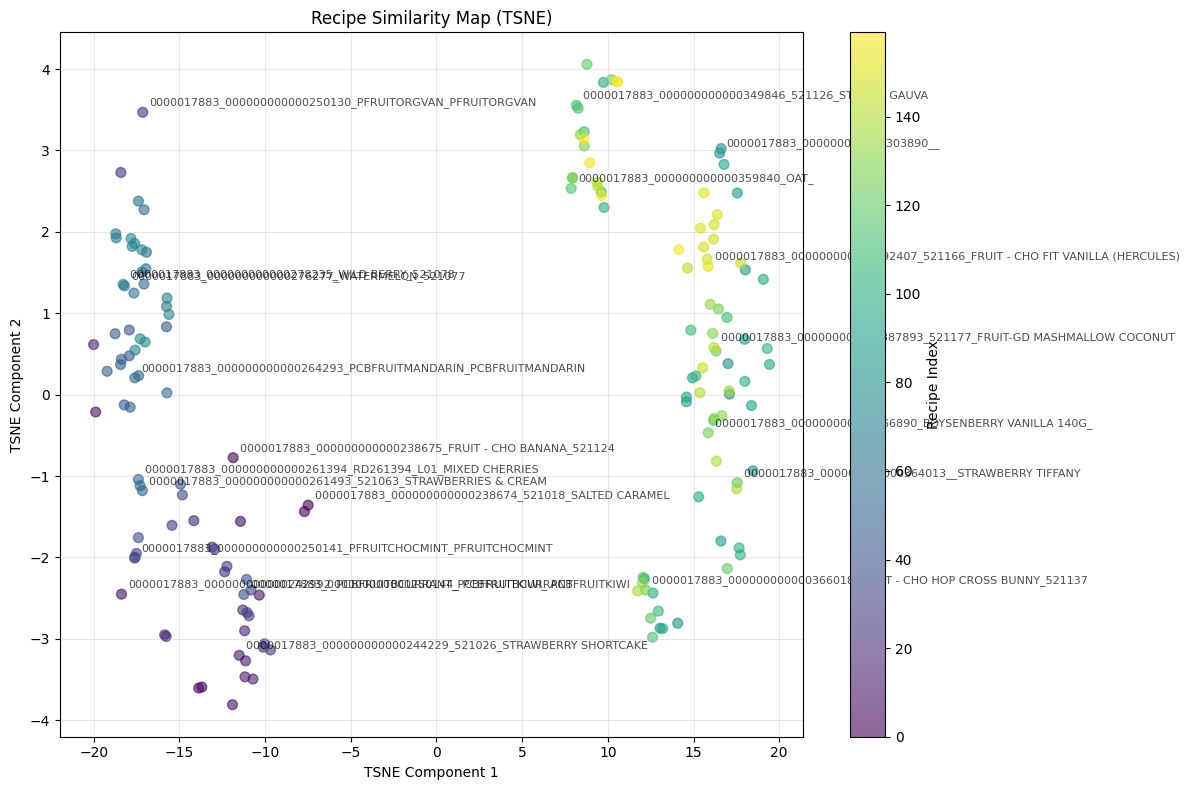

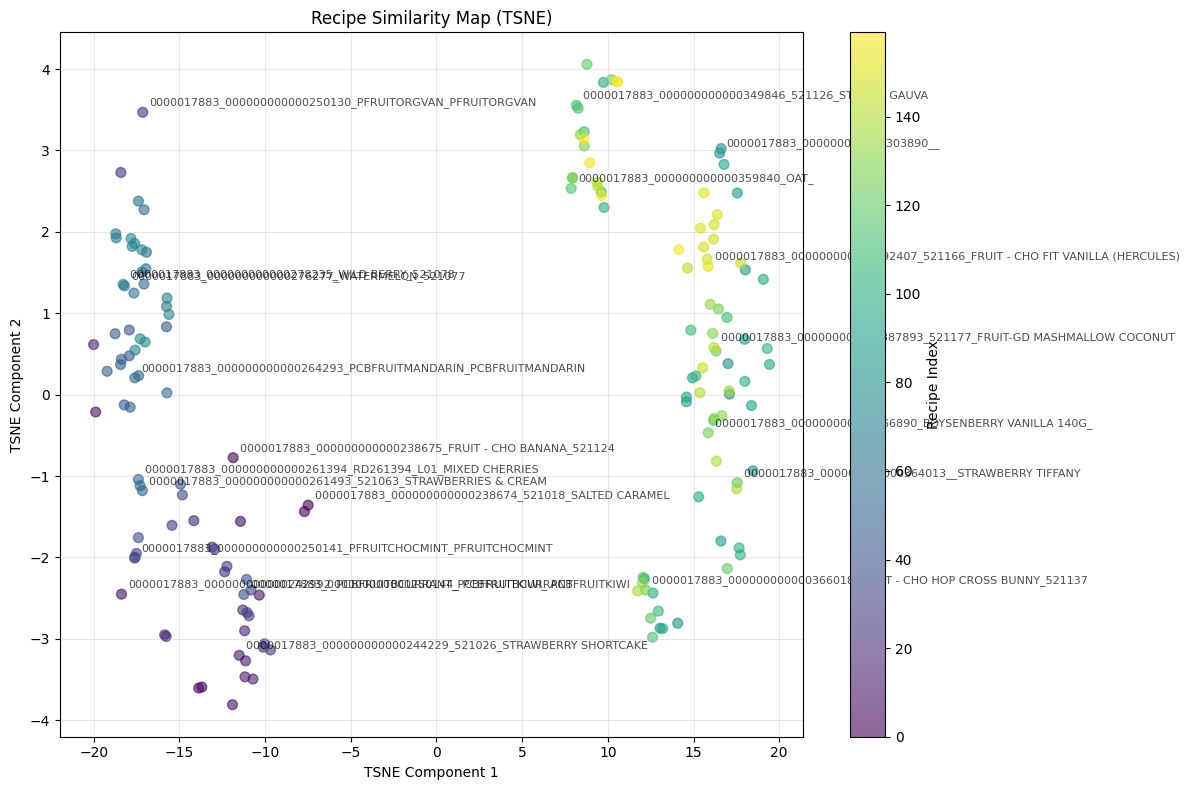

In [26]:
quick_recipe_map(manager, method='tsne')

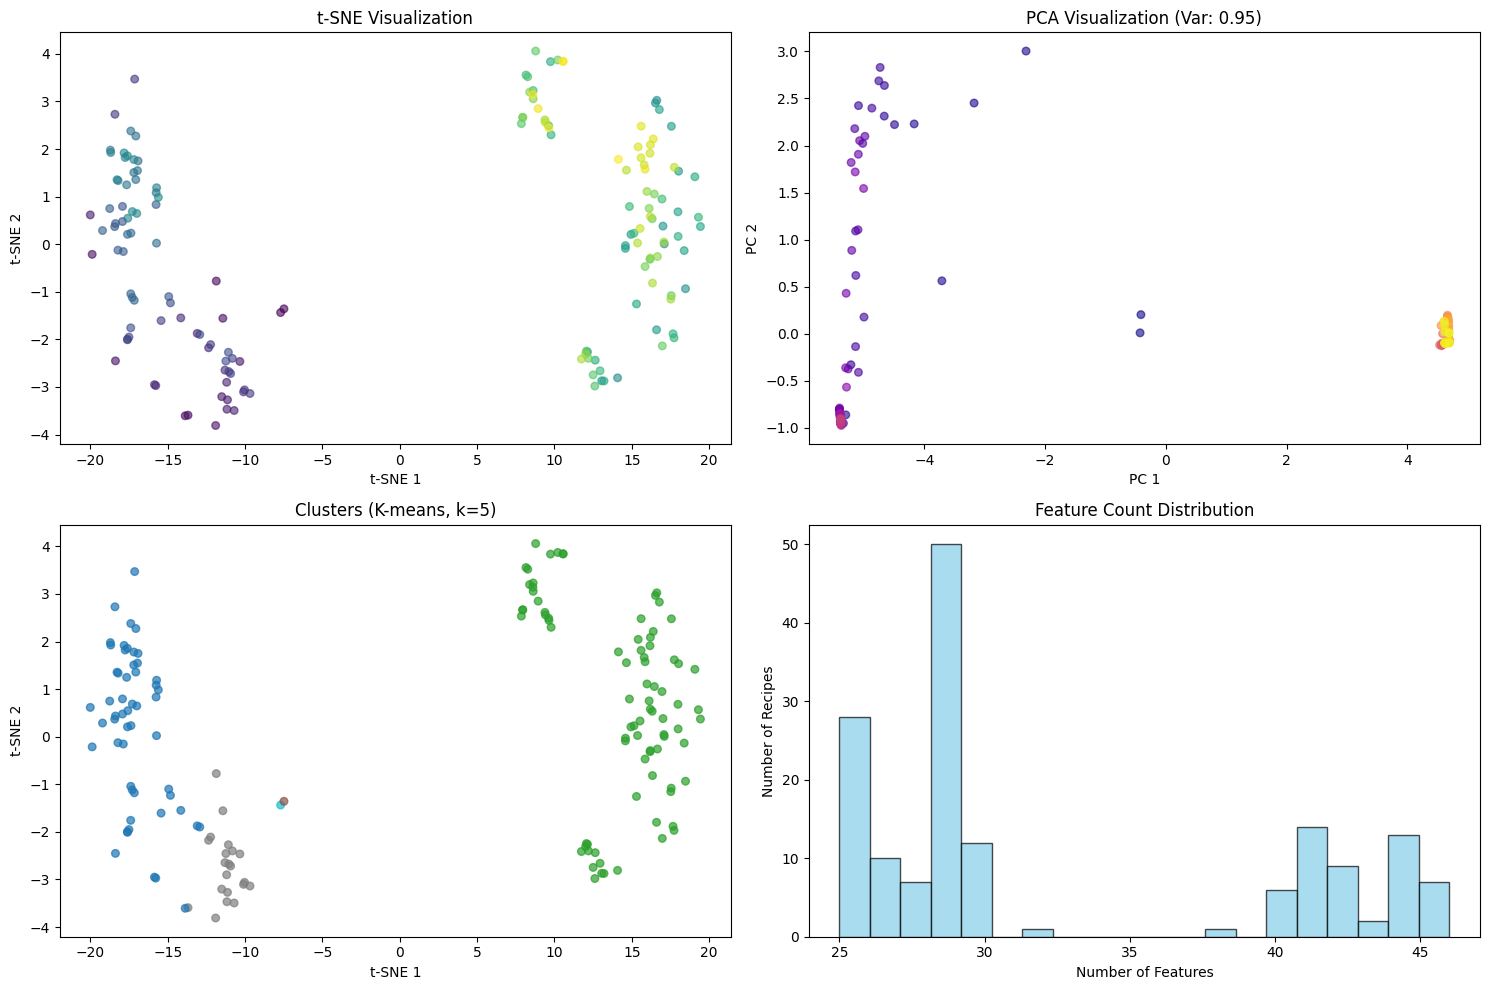

In [25]:
viz = SimpleRecipeVisualizer(manager)
dashboard = viz.create_summary_plots()
plt.show()

In [ ]:
recipe_name = "0000017883_000000000000238673_PEANUT CARAMEL_521022"
found_recipe = None
for recipe in manager.recipes:
    if recipe['payload'].get('recipe_name') == recipe_name:
        found_recipe = recipe
        break

if found_recipe:
    print(f"Direct lookup successful: {found_recipe['payload']['recipe_name']}")

In [ ]:
# 1. Create similarity map
# quick_recipe_map(manager, method='tsne')

# 2. Find similar recipes visually
recipe_name = "0000017883_000000000000238673_PEANUT CARAMEL_521022"
results_df, fig = quick_find_similar(manager, recipe_name, n_neighbors=8)

# 3. Create clusters
quick_clusters(manager, n_clusters=6)

# 4. Similarity heatmap
# quick_heatmap(manager, sample_size=30)



In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

class SimpleRecipeVisualizer:
    """matplotlib-based visualization for recipe similarity."""
    
    def __init__(self, manager):
        """Initialize with recipe manager."""
        self.manager = manager
        self.vectors = np.array(manager.vectors) if manager.vectors else None
        self.recipes = manager.recipes
        
        if self.vectors is None or len(self.vectors) == 0:
            raise ValueError("No recipes found in manager.")
    
    def plot_similarity_map(self, method='tsne', figsize=(12, 8), sample_size=None):
        """
        Create a 2D similarity map of recipes.
        
        Args:
            method: 'tsne' or 'pca'
            figsize: Figure size
            sample_size: Limit number of recipes for performance
        """
        # Sample if too many recipes
        vectors = self.vectors
        recipes = self.recipes
        
        if sample_size and len(vectors) > sample_size:
            indices = np.random.choice(len(vectors), sample_size, replace=False)
            vectors = vectors[indices]
            recipes = [self.recipes[i] for i in indices]
        
        # Reduce dimensions
        if method.lower() == 'tsne':
            reducer = TSNE(n_components=2, random_state=42, 
                          perplexity=min(30, len(vectors)-1))
        else:  # PCA
            reducer = PCA(n_components=2, random_state=42)
        
        coords = reducer.fit_transform(vectors)
        
        # Create plot
        plt.figure(figsize=figsize)
        
        # Plot points
        scatter = plt.scatter(coords[:, 0], coords[:, 1], 
                            c=range(len(coords)), cmap='viridis', 
                            alpha=0.6, s=50)
        
        # Add recipe names for a few points
        n_labels = min(20, len(coords))
        indices_to_label = np.random.choice(len(coords), n_labels, replace=False)
        
        for idx in indices_to_label:
            recipe_name = recipes[idx]['payload'].get('recipe_name', f'Recipe_{idx}')
            # Truncate long names
            short_name = recipe_name
            #short_name = recipe_name[:20] + '...' if len(recipe_name) > 20 else recipe_name
            plt.annotate(short_name, (coords[idx, 0], coords[idx, 1]), 
                        xytext=(5, 5), textcoords='offset points', 
                        fontsize=8, alpha=0.7)
        
        plt.colorbar(scatter, label='Recipe Index')
        plt.title(f'Recipe Similarity Map ({method.upper()})')
        plt.xlabel(f'{method.upper()} Component 1')
        plt.ylabel(f'{method.upper()} Component 2')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        return plt.gcf()
    
    def plot_clusters(self, n_clusters=5, method='tsne', figsize=(12, 8)):
        """Create cluster visualization."""
        # Perform clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(self.vectors)
        
        # Reduce dimensions
        if method.lower() == 'tsne':
            reducer = TSNE(n_components=2, random_state=42,
                          perplexity=min(30, len(self.vectors)-1))
        else:
            reducer = PCA(n_components=2, random_state=42)
        
        coords = reducer.fit_transform(self.vectors)
        
        # Create plot
        plt.figure(figsize=figsize)
        
        # Plot points colored by cluster
        scatter = plt.scatter(coords[:, 0], coords[:, 1], 
                            c=cluster_labels, cmap='tab10', 
                            alpha=0.7, s=50)
        
        plt.colorbar(scatter, label='Cluster')
        plt.title(f'Recipe Clusters (K-means, k={n_clusters})')
        plt.xlabel(f'{method.upper()} Component 1')
        plt.ylabel(f'{method.upper()} Component 2')
        plt.grid(True, alpha=0.3)
        
        # Add cluster statistics
        unique_clusters, counts = np.unique(cluster_labels, return_counts=True)
        cluster_info = [f"Cluster {i}: {count} recipes" for i, count in zip(unique_clusters, counts)]
        plt.figtext(0.02, 0.02, '\n'.join(cluster_info), fontsize=9, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))
        
        plt.tight_layout()
        return plt.gcf(), cluster_labels
    
    def plot_similarity_heatmap(self, sample_size=30, figsize=(10, 8)):
        """Create similarity heatmap."""
        # Sample recipes
        n_recipes = len(self.vectors)
        if n_recipes > sample_size:
            indices = np.random.choice(n_recipes, sample_size, replace=False)
            sample_vectors = self.vectors[indices]
            sample_names = [self.recipes[i]['payload'].get('recipe_name', f'Recipe_{i}')[:15] 
                           for i in indices]
        else:
            sample_vectors = self.vectors
            sample_names = [recipe['payload'].get('recipe_name', f'Recipe_{i}')[:15] 
                           for i, recipe in enumerate(self.recipes)]
        
        # Calculate similarity
        similarity_matrix = cosine_similarity(sample_vectors)
        
        # Create heatmap
        plt.figure(figsize=figsize)
        sns.heatmap(similarity_matrix, 
                   xticklabels=sample_names,
                   yticklabels=sample_names,
                   cmap='viridis', 
                   center=0.5,
                   square=True,
                   linewidths=0.1)
        
        plt.title(f'Recipe Similarity Heatmap ({len(sample_vectors)} recipes)')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        return plt.gcf()
    
    def find_similar_recipes(self, recipe_name_or_index, n_neighbors=5, plot=True, figsize=(12, 8)):
        """Find and visualize similar recipes."""
        # Find target recipe
        target_idx = None
        if isinstance(recipe_name_or_index, int):
            target_idx = recipe_name_or_index
        else:
            for i, recipe in enumerate(self.recipes):
                if recipe['payload'].get('recipe_name', '') == recipe_name_or_index:
                    target_idx = i
                    break
        
        if target_idx is None:
            raise ValueError(f"Recipe '{recipe_name_or_index}' not found")
        
        # Calculate similarities
        target_vector = self.vectors[target_idx:target_idx+1]
        similarities = cosine_similarity(target_vector, self.vectors)[0]
        
        # Get neighbors
        neighbor_indices = np.argsort(similarities)[::-1][1:n_neighbors+1]
        
        # Create results
        results = []
        for i, idx in enumerate(neighbor_indices):
            recipe = self.recipes[idx]
            results.append({
                'rank': i + 1,
                'recipe_name': recipe['payload'].get('recipe_name', f'Recipe_{idx}'),
                'similarity_score': similarities[idx],
                'recipe_index': idx
            })
        
        results_df = pd.DataFrame(results)
        
        if plot:
            # Create visualization
            reducer = TSNE(n_components=2, random_state=42,
                          perplexity=min(30, len(self.vectors)-1))
            coords = reducer.fit_transform(self.vectors)
            
            plt.figure(figsize=figsize)
            
            # Plot all recipes
            plt.scatter(coords[:, 0], coords[:, 1], 
                       c='lightblue', alpha=0.5, s=30, label='Other recipes')
            
            # Highlight neighbors
            neighbor_coords = coords[neighbor_indices]
            plt.scatter(neighbor_coords[:, 0], neighbor_coords[:, 1], 
                       c='orange', s=100, alpha=0.8, label=f'Top {n_neighbors} similar')
            
            # Highlight target
            target_coords = coords[target_idx:target_idx+1]
            plt.scatter(target_coords[:, 0], target_coords[:, 1], 
                       c='red', s=150, marker='*', label='Target recipe')
            
            # Add labels for target and neighbors
            target_name = self.recipes[target_idx]['payload'].get('recipe_name', 'Target')[:15]
            plt.annotate(f'TARGET: {target_name}', 
                        (target_coords[0, 0], target_coords[0, 1]),
                        xytext=(10, 10), textcoords='offset points',
                        fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7))
            
            for i, idx in enumerate(neighbor_indices[:5]):  # Label top 5
                name = self.recipes[idx]['payload'].get('recipe_name', f'Recipe_{idx}')[:10]
                plt.annotate(f'{i+1}. {name}', 
                           (coords[idx, 0], coords[idx, 1]),
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=8)
            
            plt.legend()
            plt.title(f'Similar Recipes to: {target_name}')
            plt.xlabel('t-SNE Component 1')
            plt.ylabel('t-SNE Component 2')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            
            return results_df, plt.gcf()
        
        return results_df
    
    def create_summary_plots(self, figsize=(15, 10)):
        """Create a summary dashboard with multiple plots."""
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # 1. t-SNE plot
        plt.sca(axes[0, 0])
        reducer = TSNE(n_components=2, random_state=42,
                      perplexity=min(30, len(self.vectors)-1))
        coords = reducer.fit_transform(self.vectors)
        plt.scatter(coords[:, 0], coords[:, 1], c=range(len(coords)), 
                   cmap='viridis', alpha=0.6, s=30)
        plt.title('t-SNE Visualization')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        
        # 2. PCA plot
        plt.sca(axes[0, 1])
        pca = PCA(n_components=2, random_state=42)
        pca_coords = pca.fit_transform(self.vectors)
        plt.scatter(pca_coords[:, 0], pca_coords[:, 1], c=range(len(pca_coords)), 
                   cmap='plasma', alpha=0.6, s=30)
        plt.title(f'PCA Visualization (Var: {pca.explained_variance_ratio_.sum():.2f})')
        plt.xlabel('PC 1')
        plt.ylabel('PC 2')
        
        # 3. Clusters
        plt.sca(axes[1, 0])
        kmeans = KMeans(n_clusters=5, random_state=42)
        cluster_labels = kmeans.fit_predict(self.vectors)
        plt.scatter(coords[:, 0], coords[:, 1], c=cluster_labels, 
                   cmap='tab10', alpha=0.7, s=30)
        plt.title('Clusters (K-means, k=5)')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        
        # 4. Feature distribution
        plt.sca(axes[1, 1])
        feature_counts = [len(recipe['payload'].get('features', [])) for recipe in self.recipes]
        plt.hist(feature_counts, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('Feature Count Distribution')
        plt.xlabel('Number of Features')
        plt.ylabel('Number of Recipes')
        
        plt.tight_layout()
        return fig


# Quick usage functions
def quick_recipe_map(manager, method='tsne', figsize=(12, 8)):
    """Quick recipe similarity map."""
    viz = SimpleRecipeVisualizer(manager)
    fig = viz.plot_similarity_map(method=method, figsize=figsize)
    plt.show()
    return fig

def quick_find_similar(manager, recipe_name, n_neighbors=5):
    """Quick similar recipe finder."""
    viz = SimpleRecipeVisualizer(manager)
    results_df, fig = viz.find_similar_recipes(recipe_name, n_neighbors=n_neighbors)
    plt.show()
    print("\nSimilar recipes:")
    print(results_df)
    return results_df, fig

def quick_clusters(manager, n_clusters=5):
    """Quick cluster analysis."""
    viz = SimpleRecipeVisualizer(manager)
    fig, labels = viz.plot_clusters(n_clusters=n_clusters)
    plt.show()
    return fig, labels

def quick_heatmap(manager, sample_size=25):
    """Quick similarity heatmap."""
    viz = SimpleRecipeVisualizer(manager)
    fig = viz.plot_similarity_heatmap(sample_size=sample_size)
    plt.show()
    return fig

if __name__ == "__main__":
    print("""
    Recipe Visualization 
    =============================================
    
    Usage:
    
    # 1. Recipe similarity map
    quick_recipe_map(manager, method='tsne')
    
    # 2. Find similar recipes
    results_df, fig = quick_find_similar(manager, 'recipe_name')
    
    # 3. Create clusters
    fig, labels = quick_clusters(manager, n_clusters=8)
    
    # 4. Similarity heatmap
    quick_heatmap(manager, sample_size=30)
    
    # 5. Full dashboard
    viz = SimpleRecipeVisualizer(manager)
    dashboard = viz.create_summary_plots()
    plt.show()
    """)


    Recipe Visualization 
    
    Usage:
    
    # 1. Recipe similarity map
    quick_recipe_map(manager, method='tsne')
    
    # 2. Find similar recipes
    results_df, fig = quick_find_similar(manager, 'recipe_name')
    
    # 3. Create clusters
    fig, labels = quick_clusters(manager, n_clusters=8)
    
    # 4. Similarity heatmap
    quick_heatmap(manager, sample_size=30)
    
    # 5. Full dashboard
    viz = SimpleRecipeVisualizer(manager)
    dashboard = viz.create_summary_plots()
    plt.show()
    


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

class SimpleRecipeVisualizer:
    """matplotlib-based visualization for recipe similarity."""
    
    def __init__(self, manager):
        """Initialize with recipe manager."""
        self.manager = manager
        self.vectors = np.array(manager.vectors) if manager.vectors else None
        self.recipes = manager.recipes
        
        if self.vectors is None or len(self.vectors) == 0:
            raise ValueError("No recipes found in manager.")
    
    def plot_similarity_map(self, method='tsne', figsize=(12, 8), sample_size=None):
        """
        Create a 2D similarity map of recipes.
        
        Args:
            method: 'tsne' or 'pca'
            figsize: Figure size
            sample_size: Limit number of recipes for performance
        """
        # Sample if too many recipes
        vectors = self.vectors
        recipes = self.recipes
        
        if sample_size and len(vectors) > sample_size:
            indices = np.random.choice(len(vectors), sample_size, replace=False)
            vectors = vectors[indices]
            recipes = [self.recipes[i] for i in indices]
        
        # Reduce dimensions
        if method.lower() == 'tsne':
            reducer = TSNE(n_components=2, random_state=42, 
                          perplexity=min(30, len(vectors)-1))
        else:  # PCA
            reducer = PCA(n_components=2, random_state=42)
        
        coords = reducer.fit_transform(vectors)
        
        # Create plot
        plt.figure(figsize=figsize)
        
        # Plot points
        scatter = plt.scatter(coords[:, 0], coords[:, 1], 
                            c=range(len(coords)), cmap='viridis', 
                            alpha=0.6, s=50)
        
        # Add recipe names for a few points
        n_labels = min(20, len(coords))
        indices_to_label = np.random.choice(len(coords), n_labels, replace=False)
        
        for idx in indices_to_label:
            recipe_name = recipes[idx]['payload'].get('recipe_name', f'Recipe_{idx}')
            # Truncate long names
            short_name = recipe_name[:20] + '...' if len(recipe_name) > 20 else recipe_name
            plt.annotate(short_name, (coords[idx, 0], coords[idx, 1]), 
                        xytext=(5, 5), textcoords='offset points', 
                        fontsize=8, alpha=0.7)
        
        plt.colorbar(scatter, label='Recipe Index')
        plt.title(f'Recipe Similarity Map ({method.upper()})')
        plt.xlabel(f'{method.upper()} Component 1')
        plt.ylabel(f'{method.upper()} Component 2')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        return plt.gcf()
    
    def plot_clusters(self, n_clusters=5, method='tsne', figsize=(12, 8)):
        """Create cluster visualization."""
        # Perform clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(self.vectors)
        
        # Reduce dimensions
        if method.lower() == 'tsne':
            reducer = TSNE(n_components=2, random_state=42,
                          perplexity=min(30, len(self.vectors)-1))
        else:
            reducer = PCA(n_components=2, random_state=42)
        
        coords = reducer.fit_transform(self.vectors)
        
        # Create plot
        plt.figure(figsize=figsize)
        
        # Plot points colored by cluster
        scatter = plt.scatter(coords[:, 0], coords[:, 1], 
                            c=cluster_labels, cmap='tab10', 
                            alpha=0.7, s=50)
        
        plt.colorbar(scatter, label='Cluster')
        plt.title(f'Recipe Clusters (K-means, k={n_clusters})')
        plt.xlabel(f'{method.upper()} Component 1')
        plt.ylabel(f'{method.upper()} Component 2')
        plt.grid(True, alpha=0.3)
        
        # Add cluster statistics
        unique_clusters, counts = np.unique(cluster_labels, return_counts=True)
        cluster_info = [f"Cluster {i}: {count} recipes" for i, count in zip(unique_clusters, counts)]
        plt.figtext(0.02, 0.02, '\n'.join(cluster_info), fontsize=9, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))
        
        plt.tight_layout()
        return plt.gcf(), cluster_labels
    
    def plot_similarity_heatmap(self, sample_size=30, figsize=(10, 8)):
        """Create similarity heatmap."""
        # Sample recipes
        n_recipes = len(self.vectors)
        if n_recipes > sample_size:
            indices = np.random.choice(n_recipes, sample_size, replace=False)
            sample_vectors = self.vectors[indices]
            sample_names = [self.recipes[i]['payload'].get('recipe_name', f'Recipe_{i}')[:15] 
                           for i in indices]
        else:
            sample_vectors = self.vectors
            sample_names = [recipe['payload'].get('recipe_name', f'Recipe_{i}')[:15] 
                           for i, recipe in enumerate(self.recipes)]
        
        # Calculate similarity
        similarity_matrix = cosine_similarity(sample_vectors)
        
        # Create heatmap
        plt.figure(figsize=figsize)
        sns.heatmap(similarity_matrix, 
                   xticklabels=sample_names,
                   yticklabels=sample_names,
                   cmap='viridis', 
                   center=0.5,
                   square=True,
                   linewidths=0.1)
        
        plt.title(f'Recipe Similarity Heatmap ({len(sample_vectors)} recipes)')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        return plt.gcf()
    
    def find_similar_recipes(self, recipe_name_or_index, n_neighbors=5, plot=True, figsize=(12, 8)):
        """Find and visualize similar recipes."""
        # Find target recipe
        target_idx = None
        if isinstance(recipe_name_or_index, int):
            target_idx = recipe_name_or_index
        else:
            for i, recipe in enumerate(self.recipes):
                if recipe['payload'].get('recipe_name', '') == recipe_name_or_index:
                    target_idx = i
                    break
        
        if target_idx is None:
            raise ValueError(f"Recipe '{recipe_name_or_index}' not found")
        
        # Calculate similarities
        target_vector = self.vectors[target_idx:target_idx+1]
        similarities = cosine_similarity(target_vector, self.vectors)[0]
        
        # Get neighbors
        neighbor_indices = np.argsort(similarities)[::-1][1:n_neighbors+1]
        
        # Create results
        results = []
        for i, idx in enumerate(neighbor_indices):
            recipe = self.recipes[idx]
            results.append({
                'rank': i + 1,
                'recipe_name': recipe['payload'].get('recipe_name', f'Recipe_{idx}'),
                'similarity_score': similarities[idx],
                'recipe_index': idx
            })
        
        results_df = pd.DataFrame(results)
        
        if plot:
            # Create visualization
            reducer = TSNE(n_components=2, random_state=42,
                          perplexity=min(30, len(self.vectors)-1))
            coords = reducer.fit_transform(self.vectors)
            
            plt.figure(figsize=figsize)
            
            # Plot all recipes
            plt.scatter(coords[:, 0], coords[:, 1], 
                       c='lightblue', alpha=0.5, s=30, label='Other recipes')
            
            # Highlight neighbors
            neighbor_coords = coords[neighbor_indices]
            plt.scatter(neighbor_coords[:, 0], neighbor_coords[:, 1], 
                       c='orange', s=100, alpha=0.8, label=f'Top {n_neighbors} similar')
            
            # Highlight target
            target_coords = coords[target_idx:target_idx+1]
            plt.scatter(target_coords[:, 0], target_coords[:, 1], 
                       c='red', s=150, marker='*', label='Target recipe')
            
            # Add labels for target and neighbors
            target_name = self.recipes[target_idx]['payload'].get('recipe_name', 'Target')[:15]
            plt.annotate(f'TARGET: {target_name}', 
                        (target_coords[0, 0], target_coords[0, 1]),
                        xytext=(10, 10), textcoords='offset points',
                        fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7))
            
            for i, idx in enumerate(neighbor_indices[:5]):  # Label top 5
                name = self.recipes[idx]['payload'].get('recipe_name', f'Recipe_{idx}')[:10]
                plt.annotate(f'{i+1}. {name}', 
                           (coords[idx, 0], coords[idx, 1]),
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=8)
            
            plt.legend()
            plt.title(f'Similar Recipes to: {target_name}')
            plt.xlabel('t-SNE Component 1')
            plt.ylabel('t-SNE Component 2')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            
            return results_df, plt.gcf()
        
        return results_df
    
    def create_summary_plots(self, figsize=(15, 10)):
        """Create a summary dashboard with multiple plots."""
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # 1. t-SNE plot
        plt.sca(axes[0, 0])
        reducer = TSNE(n_components=2, random_state=42,
                      perplexity=min(30, len(self.vectors)-1))
        coords = reducer.fit_transform(self.vectors)
        plt.scatter(coords[:, 0], coords[:, 1], c=range(len(coords)), 
                   cmap='viridis', alpha=0.6, s=30)
        plt.title('t-SNE Visualization')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        
        # 2. PCA plot
        plt.sca(axes[0, 1])
        pca = PCA(n_components=2, random_state=42)
        pca_coords = pca.fit_transform(self.vectors)
        plt.scatter(pca_coords[:, 0], pca_coords[:, 1], c=range(len(pca_coords)), 
                   cmap='plasma', alpha=0.6, s=30)
        plt.title(f'PCA Visualization (Var: {pca.explained_variance_ratio_.sum():.2f})')
        plt.xlabel('PC 1')
        plt.ylabel('PC 2')
        
        # 3. Clusters
        plt.sca(axes[1, 0])
        kmeans = KMeans(n_clusters=5, random_state=42)
        cluster_labels = kmeans.fit_predict(self.vectors)
        plt.scatter(coords[:, 0], coords[:, 1], c=cluster_labels, 
                   cmap='tab10', alpha=0.7, s=30)
        plt.title('Clusters (K-means, k=5)')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        
        # 4. Feature distribution
        plt.sca(axes[1, 1])
        feature_counts = [len(recipe['payload'].get('features', [])) for recipe in self.recipes]
        plt.hist(feature_counts, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('Feature Count Distribution')
        plt.xlabel('Number of Features')
        plt.ylabel('Number of Recipes')
        
        plt.tight_layout()
        return fig


# Quick usage functions
def quick_recipe_map(manager, method='tsne', figsize=(12, 8)):
    """Quick recipe similarity map."""
    viz = SimpleRecipeVisualizer(manager)
    fig = viz.plot_similarity_map(method=method, figsize=figsize)
    plt.show()
    return fig

def quick_find_similar(manager, recipe_name, n_neighbors=5):
    """Quick similar recipe finder."""
    viz = SimpleRecipeVisualizer(manager)
    results_df, fig = viz.find_similar_recipes(recipe_name, n_neighbors=n_neighbors)
    plt.show()
    print("\nSimilar recipes:")
    print(results_df)
    return results_df, fig

def quick_clusters(manager, n_clusters=5):
    """Quick cluster analysis."""
    viz = SimpleRecipeVisualizer(manager)
    fig, labels = viz.plot_clusters(n_clusters=n_clusters)
    plt.show()
    return fig, labels

def quick_heatmap(manager, sample_size=25):
    """Quick similarity heatmap."""
    viz = SimpleRecipeVisualizer(manager)
    fig = viz.plot_similarity_heatmap(sample_size=sample_size)
    plt.show()
    return fig

if __name__ == "__main__":
    print("""
    Recipe Visualization 
    =============================================
    
    Usage:
    
    # 1. Recipe similarity map
    quick_recipe_map(manager, method='tsne')
    
    # 2. Find similar recipes
    results_df, fig = quick_find_similar(manager, 'recipe_name')
    
    # 3. Create clusters
    fig, labels = quick_clusters(manager, n_clusters=8)
    
    # 4. Similarity heatmap
    quick_heatmap(manager, sample_size=30)
    
    # 5. Full dashboard
    viz = SimpleRecipeVisualizer(manager)
    dashboard = viz.create_summary_plots()
    plt.show()
    """)


    Recipe Visualization 
    
    Usage:
    
    # 1. Recipe similarity map
    quick_recipe_map(manager, method='tsne')
    
    # 2. Find similar recipes
    results_df, fig = quick_find_similar(manager, 'recipe_name')
    
    # 3. Create clusters
    fig, labels = quick_clusters(manager, n_clusters=8)
    
    # 4. Similarity heatmap
    quick_heatmap(manager, sample_size=30)
    
    # 5. Full dashboard
    viz = SimpleRecipeVisualizer(manager)
    dashboard = viz.create_summary_plots()
    plt.show()
    


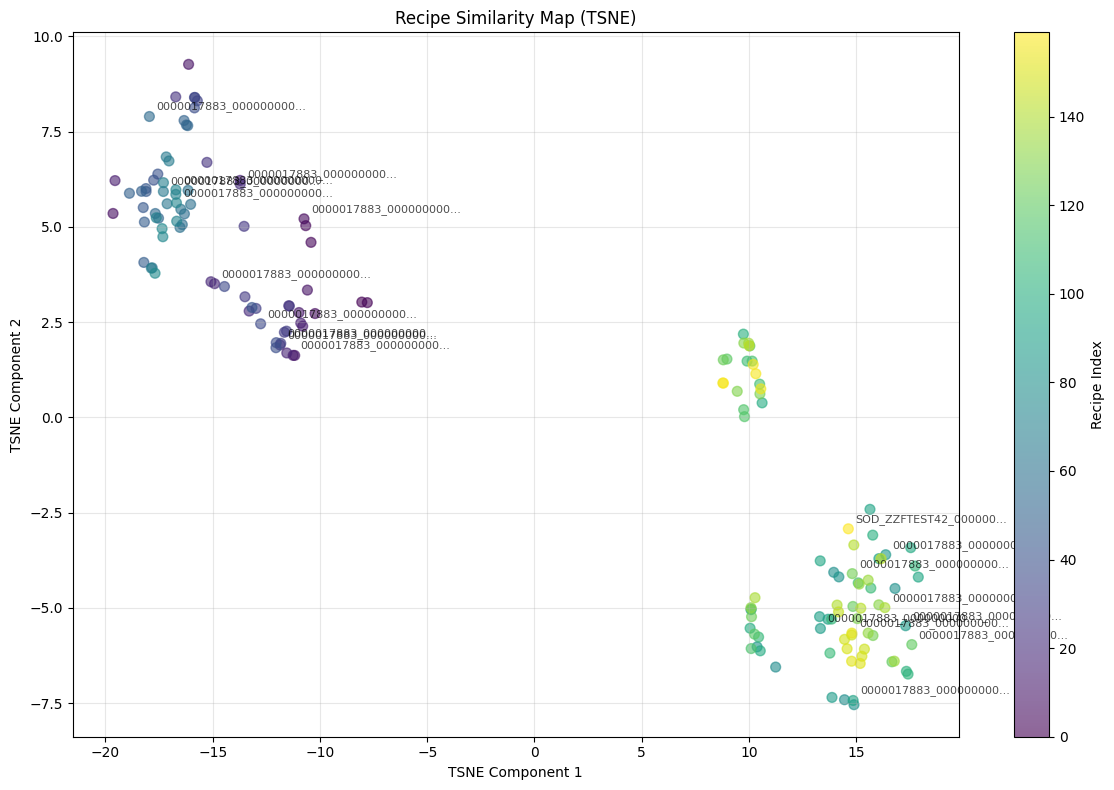

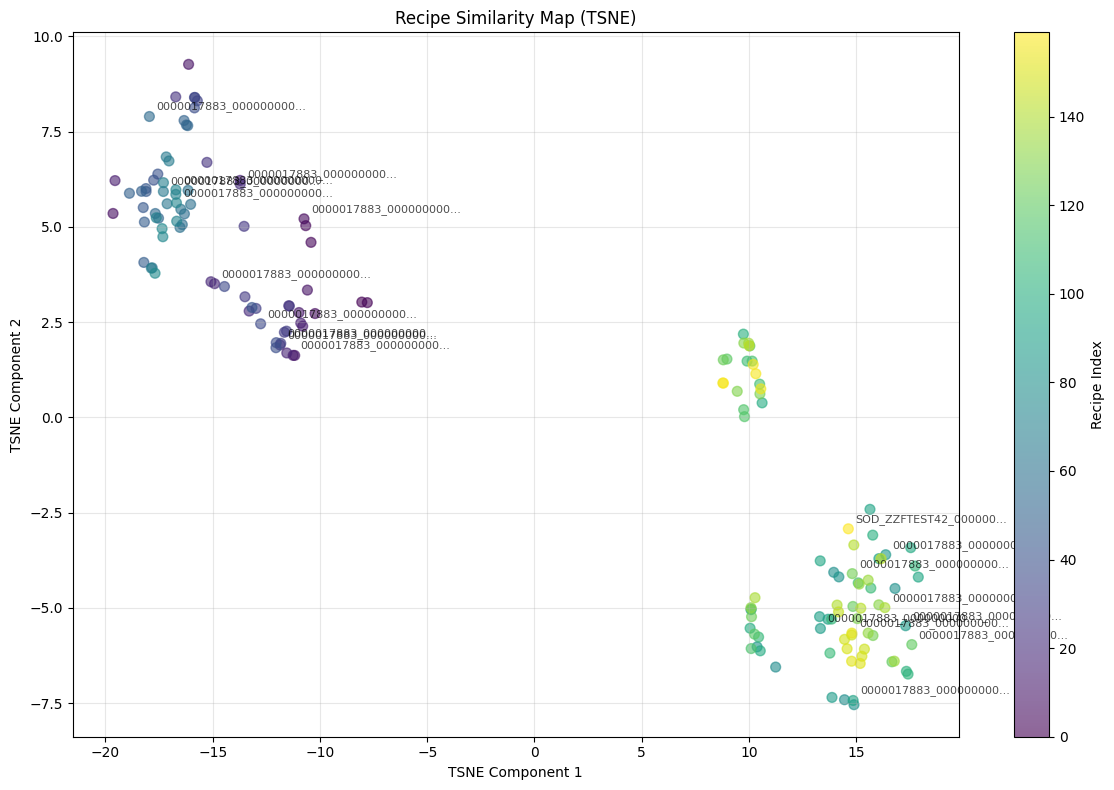

In [41]:
quick_recipe_map(manager, method='tsne')

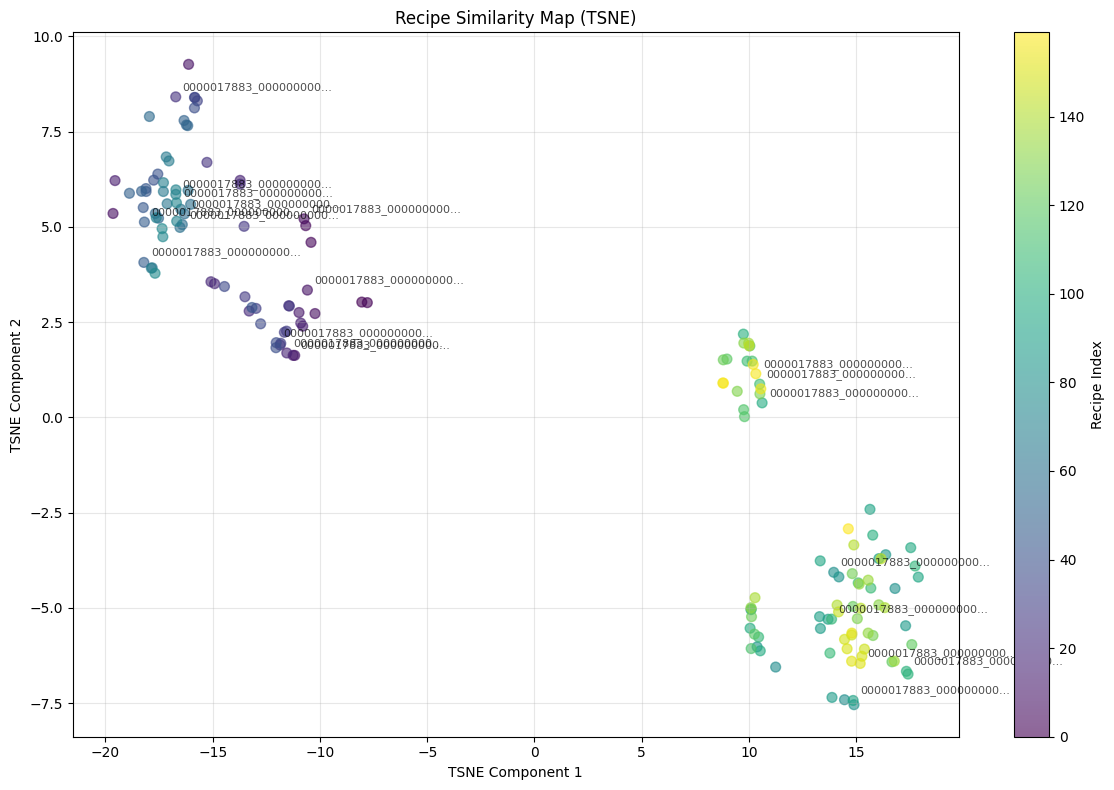

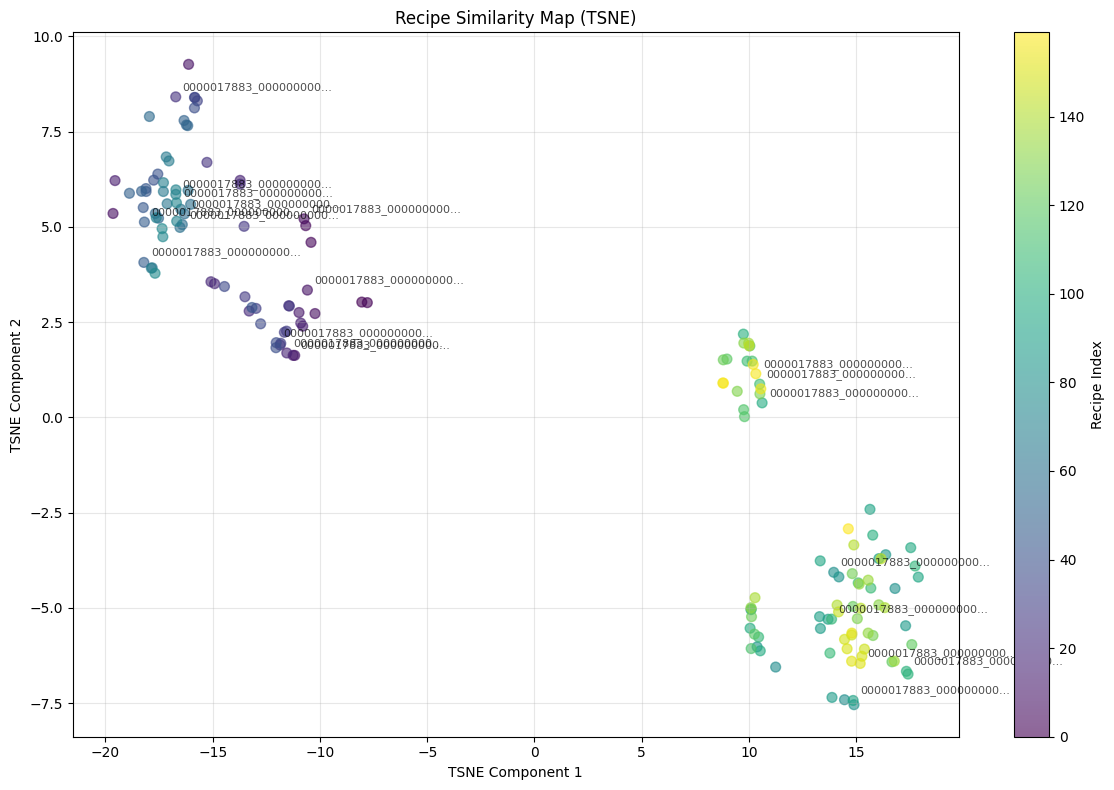

In [37]:
quick_recipe_map(manager, method='tsne')

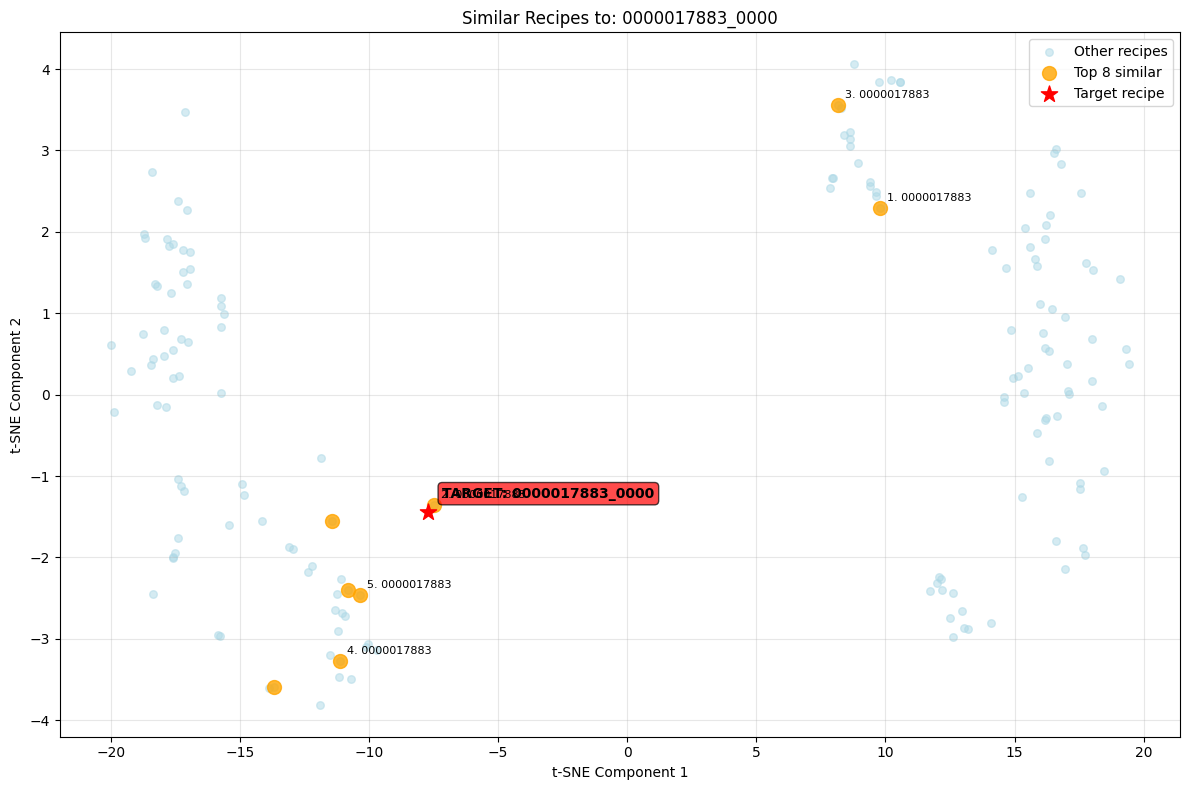


Similar recipes:
   rank                                        recipe_name  similarity_score  \
0     1  0000017883_000000000000339945_SALTED CARAMEL V...          0.140028   
1     2  0000017883_000000000000238674_521018_SALTED CA...          0.140028   
2     3  0000017883_000000000000349846_521126_STRAWB GAUVA          0.139710   
3     4      0000017883_000000000000247931_521019_KEY LIME          0.139664   
4     5     0000017883_000000000000244779_CHOC HAZE_521023          0.139467   
5     6  0000017883_000000000000250138_PFRUITORGVANBEAN...          0.139362   
6     7  0000017883_000000000000241022_521025_MANGO PAS...          0.139244   
7     8  0000017883_000000000000240905_PCBFRUITPCHBANAN...          0.139239   

   recipe_index  
0           101  
1             1  
2           109  
3            11  
4            10  
5            31  
6             5  
7             3  


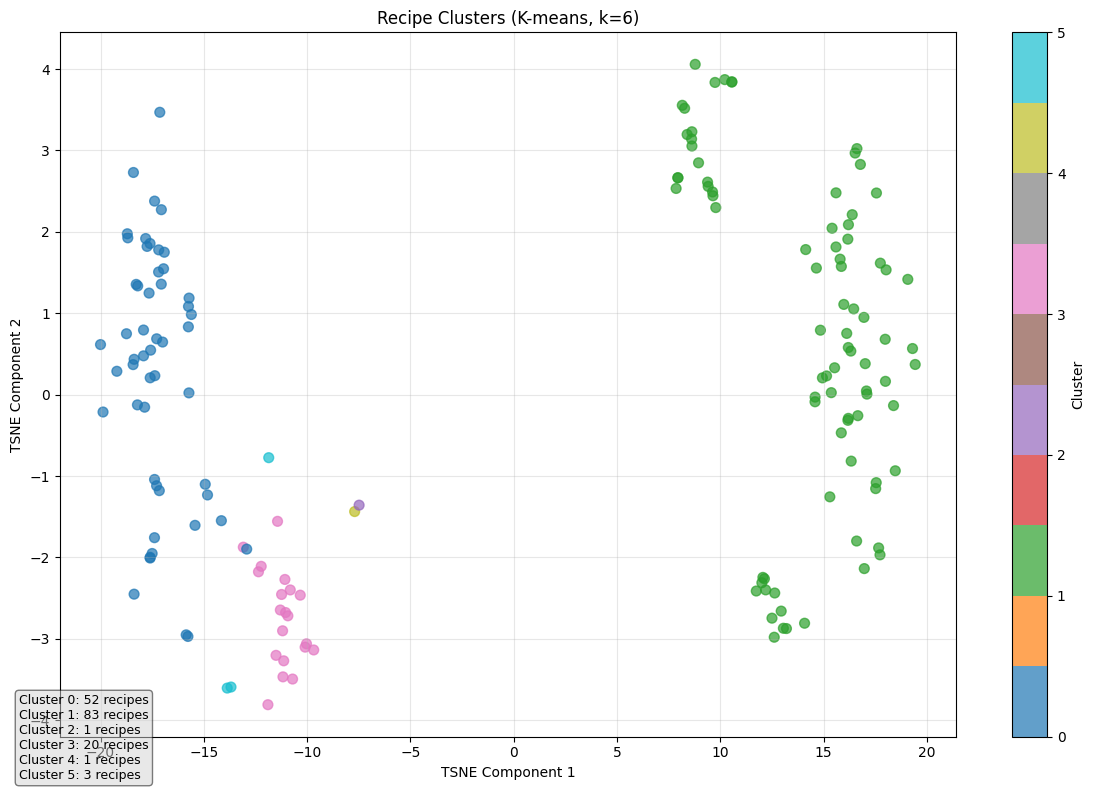

(<Figure size 1200x800 with 2 Axes>,
 array([4, 2, 5, 5, 5, 3, 0, 0, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 0, 3, 0, 3,
        3, 0, 0, 3, 3, 3, 3, 3, 0, 3, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1], dtype=int32))

In [22]:
# 1. Create similarity map
# quick_recipe_map(manager, method='tsne')

# 2. Find similar recipes visually
recipe_name = "0000017883_000000000000238673_PEANUT CARAMEL_521022"
results_df, fig = quick_find_similar(manager, recipe_name, n_neighbors=8)

# 3. Create clusters
quick_clusters(manager, n_clusters=6)

# 4. Similarity heatmap
# quick_heatmap(manager, sample_size=30)



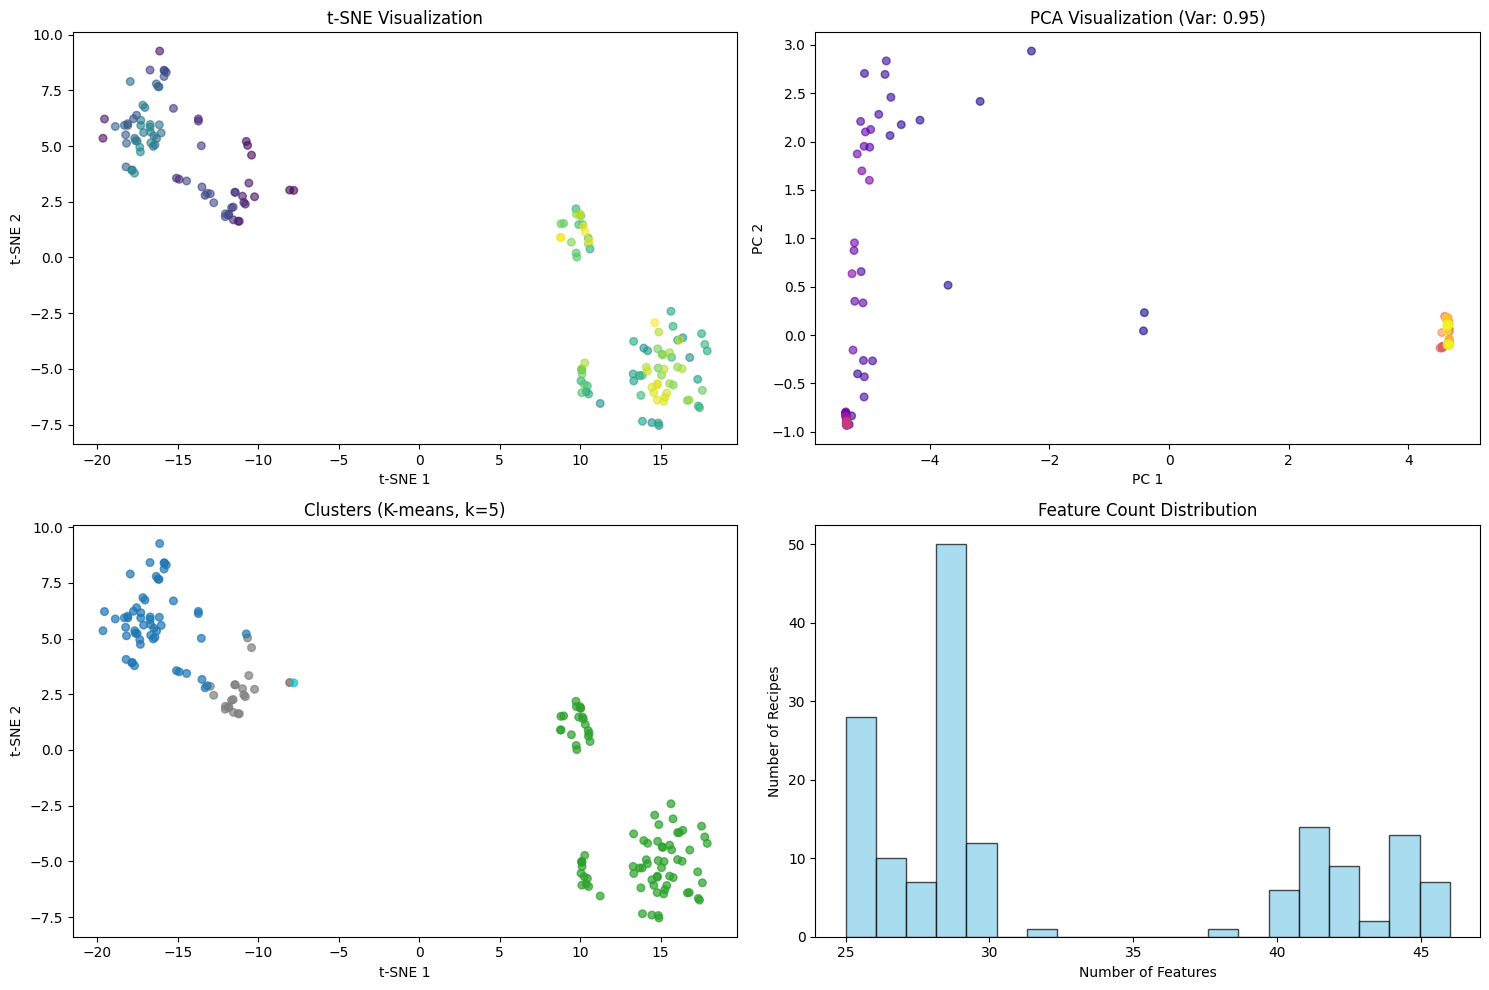

In [36]:
viz = SimpleRecipeVisualizer(manager)
dashboard = viz.create_summary_plots()
plt.show()

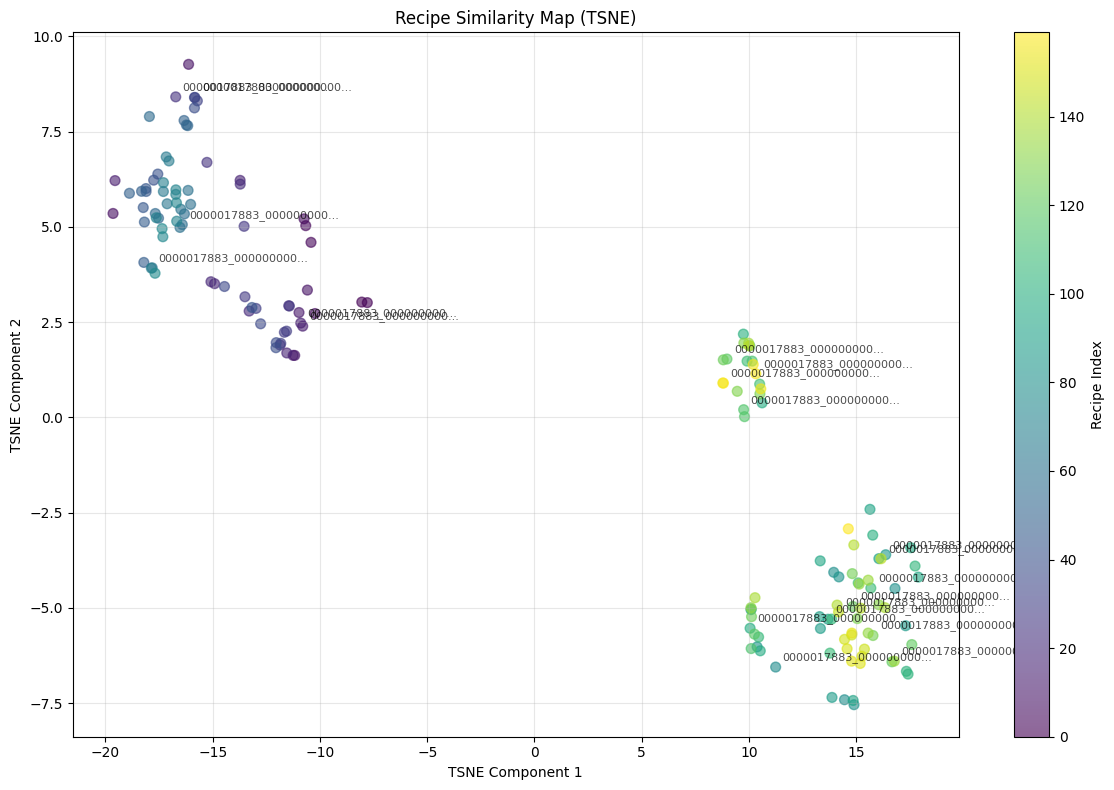

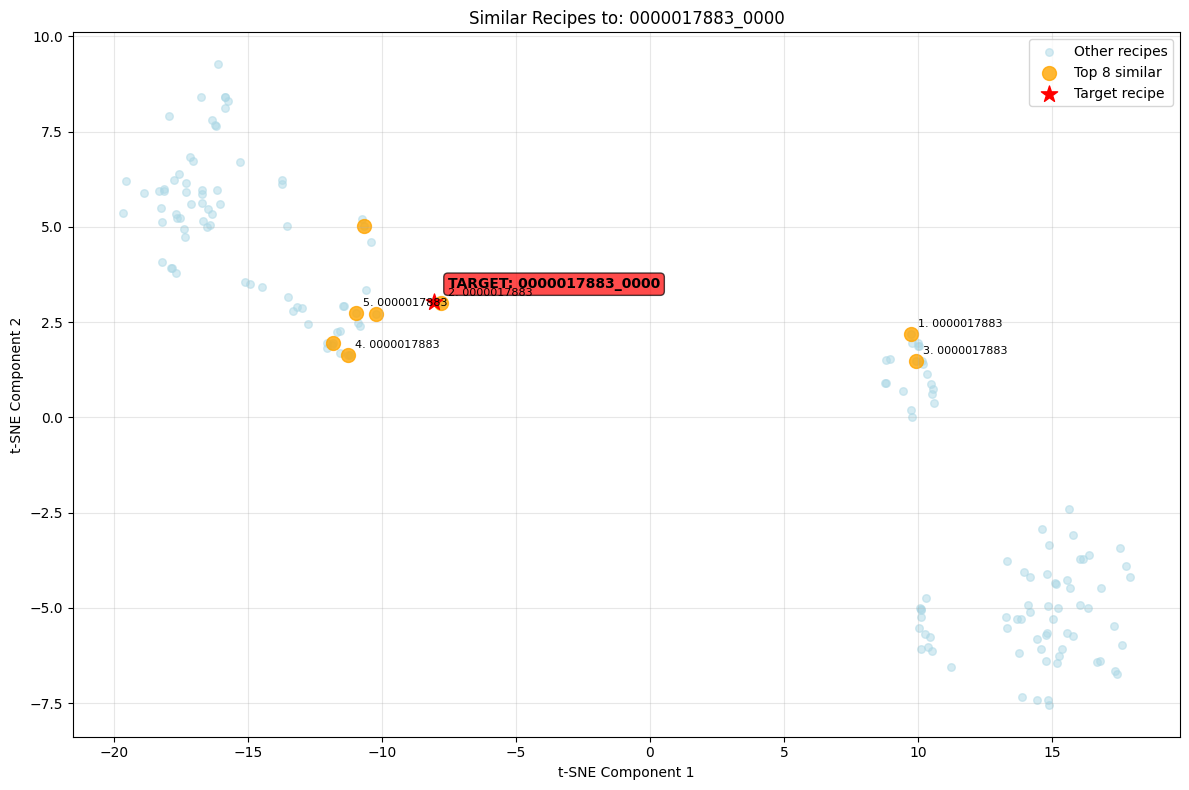


Similar recipes:
   rank                                        recipe_name  similarity_score  \
0     1  0000017883_000000000000339945_SALTED CARAMEL V...          0.140028   
1     2  0000017883_000000000000238674_521018_SALTED CA...          0.140028   
2     3  0000017883_000000000000349846_521126_STRAWB GAUVA          0.139710   
3     4      0000017883_000000000000247931_521019_KEY LIME          0.139664   
4     5     0000017883_000000000000244779_CHOC HAZE_521023          0.139467   
5     6  0000017883_000000000000250138_PFRUITORGVANBEAN...          0.139362   
6     7  0000017883_000000000000241022_521025_MANGO PAS...          0.139244   
7     8  0000017883_000000000000240905_PCBFRUITPCHBANAN...          0.139239   

   recipe_index  
0           101  
1             1  
2           109  
3            11  
4            10  
5            31  
6             5  
7             3  


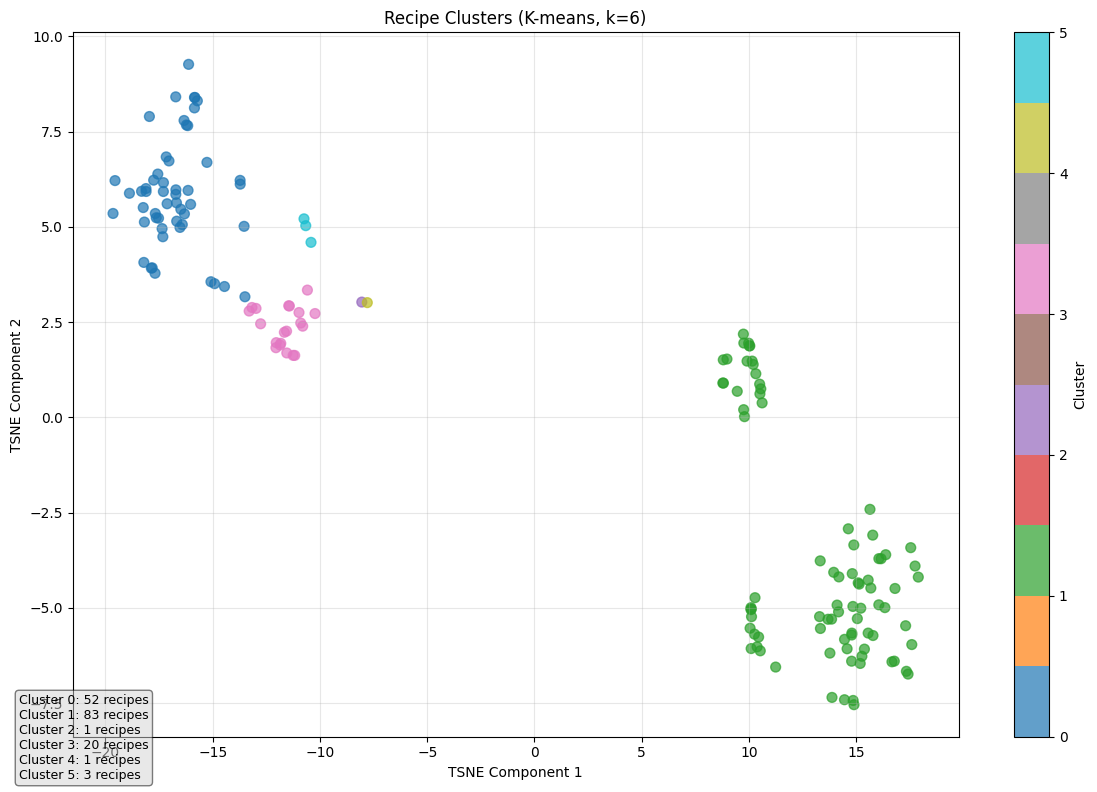

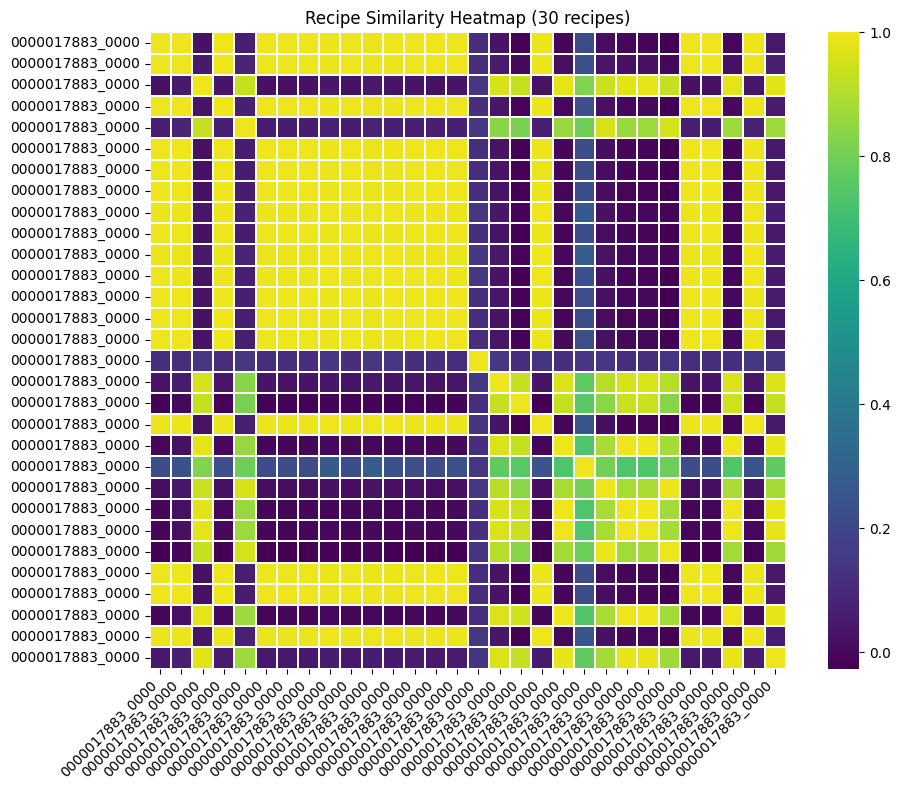

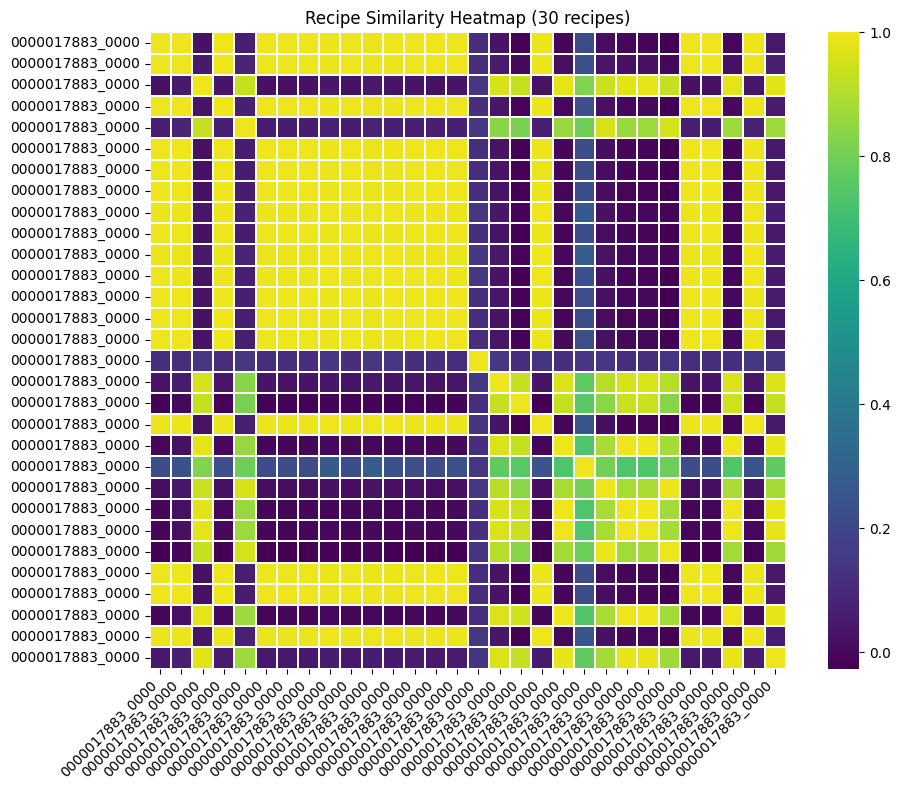

In [33]:
# 1. Create similarity map
quick_recipe_map(manager, method='tsne')

# 2. Find similar recipes visually
recipe_name = "0000017883_000000000000238673_PEANUT CARAMEL_521022"
results_df, fig = quick_find_similar(manager, recipe_name, n_neighbors=8)

# 3. Create clusters
quick_clusters(manager, n_clusters=6)

# 4. Similarity heatmap
quick_heatmap(manager, sample_size=30)

